# Worldmaps
This script is able to make all worldmaps in the paper. 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import seaborn as sns
from xclim.indices import standardized_precipitation_evapotranspiration_index
import spei as si  # si for standardized index
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from scipy import stats
import matplotlib.ticker as mticker
import colormaps as cmaps
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap


## Definitions

### Plot

Definition that is able to make all the worldmaps

In [2]:
def plot_worldmap_with_regions_with_dist_percentage(input_data, style, resolution, discrete_cmap, vmin, vmax, cbar_label, extend, focus_regions, contour_color_region, contour_color_global, arrowcolor, xmin_dist, xmax_dist, xticks, ymin_dist, ymax_dist, yticks, vline, plot, bin_linspace, cmap_discrete_combined, dir, title, savefig = False, discrete_colors = None):

    #load the landcover map of 2022
    lc = xr.open_dataset("/scratch/ruiij001/Data/Landcover/newest/regrid/C3S-LC-L4-LCCS-Map-0_1_degrees-P1Y-2022-v2.1.1.nc").lccs_class.sel(time = "2022-01-01")
    
    # Define the types, titles, and colors
    cropland_rainfed = np.arange(9, 13)
    cropland_irrigated = np.arange(19, 21)
    broadleaved = np.arange(49, 63)
    needleleaved = np.arange(69, 83)
    shrubland = np.arange(119, 123)
    grassland = np.arange(129, 131)
    urban = np.arange(189, 191)

    types = [cropland_rainfed, cropland_irrigated, broadleaved, needleleaved, shrubland, grassland, urban]
    titles = ["Cropland, rainfed", "Cropland, irrigated", "Tree cover, broadleaved", "Tree cover, needleleaved", "Shrubland", "Grassland", "Urban areas"]
    titles_short = ["CR", "CI", "TB", "TN", "SR", "GR", "UR"]
    colors = ['#FFD700', '#32CD32', '#8B008B', '#FFA500', '#00BFFF', '#FF69B4', '#708090']

    # Choose the style of the plot
    if style == "black":
        plt.style.use('dark_background')
    if style == "white":
        plt.style.use('default')

    # Plot the worldmap 
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=11)}, figsize=(16, 9))
    ax.axis('off')
    im = input_data.where(lc != 220).where(lc != 210).where(lc != 200).where(lc != 150).sel(lat = slice(-60,90)).plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=discrete_cmap, vmin = vmin, vmax = vmax)

    if style == "white":
         ax.add_feature(cfeature.COASTLINE)
         
    ax.add_feature(cfeature.LAND)
    ax.set_ylim([-62,90])
    ax.set_title("", color='black')  
    
    # Add colorbar for the map
    if plot == "extreme_based":
        
        if focus_regions == True:
            cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.9])
        else:
            cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
        
        cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical', pad=0.08)
        cb.set_label(cbar_label, labelpad=15)
        # Adjust the ticks and labels
        ticks = np.arange(1, 25, 1) - 0.5  # All integers from 1 to 24
        labels = [str(i) for i in range(1, 25)]  # All numbers from 1 to 24
        cb.set_ticks(ticks)
        cb.set_ticklabels(labels)
        
    elif plot == 'number_of_MYDs':
        legend_patches = [mpatches.Patch(color=color, label=i) for i, color in enumerate(discrete_colors)]
        #bbox_to_anchor=(0.62, 0.11)
        legend = plt.legend(handles=legend_patches, title='Number of multi-year droughts', title_fontsize='large', loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=len(discrete_colors),prop={'size':12}, framealpha = 1)
        
        
    else:
        if focus_regions == True:
            cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.9])
        else:
            cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
        cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical', pad=0.08, extend = extend)
        cb.set_label(cbar_label, labelpad=15)
        
        if plot =='MYD_ND_EVI_difference' or plot == 'MYD_ND_EVI_difference_sum':
            # Number of discrete colors to use
            num_colors = 30

            # Get the 'curl_r' colormap
            cmap = plt.cm.get_cmap('curl_r', num_colors)

            # Define brightness change parameters
            outer_brightness = 0.01
            middle_brightness = 0.2

            # Calculate brightness changes
            brightness_changes = np.linspace(outer_brightness, middle_brightness, num_colors // 2)

            # Modify the colors to make yellow and green lighter
            colors2 = cmap(np.linspace(0, 1, num_colors))
            colors2[:num_colors // 2] += brightness_changes[:, np.newaxis]  # Increase brightness for yellow
            colors2[num_colors // 2:] += brightness_changes[::-1][:, np.newaxis]  # Increase brightness for green

            # Ensure colors stay within the valid RGBA range of 0 to 1
            colors2 = colors2.clip(0.0, 1.0)
            # Get the end colors of the colormap
            start_color = colors2[0]  # First color in the colormap
            end_color = colors2[-1]  # Last color in the colormap

            # Convert the RGBA colors to a format suitable for text color
            start_color_rgb = start_color[:3]  # Ignore the alpha value
            end_color_rgb = end_color[:3]  # Ignore the alpha value

            # Add annotations to the colorbar with the colormap end colors
            fontsize  = 9
            cb.ax.text(3.05, 0.02, ' More negative \n impact of MYDs', ha='center', va='bottom', transform=cb.ax.transAxes, color=start_color_rgb, fontsize=fontsize, rotation=90)
            cb.ax.text(3.05, 0.98, ' More negative \n impact of NDs', ha='center', va='top', transform=cb.ax.transAxes, color=end_color_rgb, fontsize=fontsize, rotation=90)
            
            arrowprops = dict(color = arrowcolor, arrowstyle='->')
            if plot != 'MYD_ND_EVI_difference_sum':
                # Add arrows from title to text
                plt.annotate('', xy=(1.11, 0.975),  xycoords=ax.transAxes,
                                xytext=(1.11, 0.64), textcoords=ax.transAxes, arrowprops=arrowprops)
                plt.annotate('', xy=(1.11, 0.05),  xycoords=ax.transAxes,
                                xytext=(1.11, 0.36), textcoords=ax.transAxes, arrowprops=arrowprops)
            else:
                plt.annotate('', xy=(1.105, 0.975),  xycoords=ax.transAxes,
                                xytext=(1.105, 0.67), textcoords=ax.transAxes, arrowprops=arrowprops)
                plt.annotate('', xy=(1.105, 0.05),  xycoords=ax.transAxes,
                                xytext=(1.105, 0.33), textcoords=ax.transAxes, arrowprops=arrowprops)
                
        # elif plot == 'mean_months_per_MYD':
        #     cb.set_ticks([12,14,16,18,20,22,24,26,28,30,32,34,36])
                

    if focus_regions == True:
        # Include the focus regions into the plot
        regions = ["BAH","AUS","WEU","SA","ARG","CAL"]

        for region_name in regions:
            print(region_name)
            if region_name == "IND": 
                reg_lat = slice(7, 33)
                reg_lon = slice(68, 94)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_IND_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.6652
                bottom = 0.79
                inset_center_x = 0.7
                inset_center_y = 0.6
            elif region_name == "BAH": 
                reg_lat = slice(19,37) 
                reg_lon = slice(81,99)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_Brahmaputra_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.6652
                bottom = 0.79
                inset_center_x = 0.725
                inset_center_y = 0.604
            elif region_name == "AUS":
                reg_lat = slice(-39.9, -19.9)
                reg_lon = slice(135, 155)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_AUS_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.6652
                bottom = -0.1
                inset_center_x = 0.88
                inset_center_y = 0.175
            elif region_name == "WEU":
                reg_lat = slice(41, 57)
                reg_lon = slice(-2, 14)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_WEU_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.36235
                bottom = 0.79
                inset_center_x = 0.49
                inset_center_y = 0.76
            elif region_name == "SA":
                reg_lat = slice(-37, -15)
                reg_lon = slice(13, 35)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_SA_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.36235
                bottom = -0.1
                inset_center_x = 0.525
                inset_center_y = 0.195
            elif region_name == "ARG":
                reg_lat = slice(-56, -26)
                reg_lon = slice(-80, -50)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_ARG_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.0595
                bottom = -0.1
                inset_center_x = 0.272
                inset_center_y = 0.16
            elif region_name == "CAL":
                reg_lat = slice(30, 43)
                reg_lon = slice(-126, -113)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_CAL_0_1_degrees_new.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.0595
                bottom = 0.79
                inset_center_x = 0.13
                inset_center_y = 0.662

            # Where to put the subplot
            left, bottom, width, height = [left, bottom, 0.3, 0.3]
            ax_inset = fig.add_axes([left, bottom, width, height], projection=ccrs.PlateCarree())
            
            # Plot the focus regions
            input_data_region = input_data.where(lc != 220).where(lc != 210).where(lc != 200).where(lc != 150).sel(lon = reg_lon, lat = reg_lat).where(region_mask == 1)
            lc_region = lc.sel(lon = reg_lon, lat = reg_lat).where(region_mask == 1)
            im = input_data_region.plot(ax=ax_inset, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=discrete_cmap, vmin = vmin, vmax = vmax)
            ax_inset.add_feature(cfeature.BORDERS)
            ax_inset.add_feature(cfeature.LAND)

            if style == "white":
                    ax_inset.add_feature(cfeature.COASTLINE)
                    ax_inset.set_title("", color='white') 
            else:
                ax_inset.set_title("", color='black') 

            # Load the land/sea mask so that the contours are not in the water
            lsm = xr.open_dataset("/scratch/ruiij001/Data/Masks/land_sea/land-sea-mask_0_1_degrees.nc").lsm.mean("time").sel(lat=reg_lat, lon=reg_lon)
            ax_inset.contour(region_mask.where(lsm > 0.5).lon, region_mask.where(lsm > 0.5).lat, np.isnan(region_mask.where(lsm > 0.5)), colors=contour_color_region, linewidths=2, transform=ccrs.PlateCarree())
            ax.contour(region_mask.where(lsm > 0.5).lon, region_mask.where(lsm > 0.5).lat, np.isnan(region_mask.where(lsm > 0.5)), colors=contour_color_global, linewidths=2, transform=ccrs.PlateCarree())
            
            # Draw arrows from the global plot to the focus region plots
            arrowprops = dict(arrowstyle="->", linewidth=2, color=arrowcolor)
            if bottom > 0.5:
                plt.annotate('', xy=(0.5, 0.01), xycoords=ax_inset.transAxes, xytext=(inset_center_x, inset_center_y), textcoords=ax.transAxes, arrowprops=arrowprops)
            else:
                if region_name == "ARG":
                    plt.annotate('', xy=(0.9, 0.99), xycoords=ax_inset.transAxes, xytext=(inset_center_x, inset_center_y), textcoords=ax.transAxes, arrowprops=arrowprops)
                else:
                    plt.annotate('', xy=(0.5, 0.99), xycoords=ax_inset.transAxes, xytext=(inset_center_x, inset_center_y), textcoords=ax.transAxes, arrowprops=arrowprops)

            # Plot the density distributions underneath every subplot
            dfs = []
            for type_, title_ in zip(types, titles):
                print(type_,input_data_region.where(np.isin(lc_region, type_)).count())
                if input_data_region.where(np.isin(lc_region, type_)).count() > 10:
                    data = pd.DataFrame({'DATA': input_data_region.where(np.isin(lc_region, type_)).values.ravel(), 'Landcover': title_})
                else: 
                    data = pd.DataFrame({'DATA': input_data_region.where(np.isin(lc_region, type_)).values.ravel() * np.nan, 'Landcover': title_})
                    #print(data)
                
                dfs.append(data)
                
            data_concat = pd.concat(dfs, ignore_index=True)
            
            
            if bottom > 0.5:
                left, bottom, width, height = [left+0.06524, 1.11, 0.16845, 0.1]
            else:
                left, bottom, width, height = [left+0.06524,-0.22, 0.16845, 0.1]
            ax_inset2 = fig.add_axes([left, bottom, width, height])

            sns.kdeplot(data=data_concat, x='DATA', hue='Landcover',  fill=True, ax = ax_inset2, common_norm=False, palette=colors, legend= False, bw_adjust=1)
            
            if left > 0.2:
                ax_inset2.set_ylabel("", color='white')
                ax_inset2.set_yticks([])
                ax_inset2.set_yticklabels([])
                ax_inset2.set_xlabel("", color='white') 
            
            if left < 0.2:
                ax_inset2.set_xlabel(cbar_label) 
                #ax_inset2.set_ylabel("Intensity")
                if bottom > 0.5:
                    x_label_position = 'top'
                    ax_inset2.xaxis.set_label_position(x_label_position)
            
            if bottom > 0.5:
                x_ticks_position = 'top'
                ax_inset2.xaxis.set_ticks_position(x_ticks_position)
            
            ax_inset2.set_title("", color='white')  
            ax_inset2.set_xlim([xmin_dist, xmax_dist])
            if yticks:
                ax_inset2.set_yticks(yticks)
            if xticks:
                ax_inset2.set_xticks(xticks)
            ax_inset2.set_ylim([ymin_dist, ymax_dist])
            if vline == True:
                ax_inset2.vlines(x=0, ymin = 0, ymax = 4, linewidth=1, color='black', linestyle = 'dashed')
            
        # Create legend patches
        patches = [Patch(color=color, label=title_) for color, title_ in zip(colors, titles_short)]
        
        # Add the legend
        #fig.legend(handles=patches, loc='lower center', ncol=len(titles_short), bbox_to_anchor=(0.3, -0.33))
        fig.legend(handles=patches, loc='center left', ncol=1, bbox_to_anchor=(0.915, -0.107), frameon=True, labelspacing = 1.2)  # Adjust bbox_to_anchor as needed

        
    # Create the fractions plot
    # boxplot_ax = fig.add_axes([0.165, 0.25, 0.11, 0.22])  # Adjust these values to position the boxplot subplot as desired 
    #left, bottom, width, height

    # Calculate fraction of SPEI time-scale values for each landcover category
    if plot == "extreme_based":
        boxplot_ax = fig.add_axes([0.165, 0.25, 0.11, 0.22])  # Adjust these values to position the boxplot subplot as desired 
        fractions = []
        for i in range(1, 25):
            fraction = []
            for type_ in types:
                SPEI_landcover = input_data.where(lc != 220).where(lc != 210).where(lc != 200).where(lc != 150).where(lc.isin(type_))
                fraction.append(np.sum(SPEI_landcover == i) / np.sum(SPEI_landcover.notnull()) * 100)
            fractions.append(fraction)
        # Plot the stacked bar plot
        bar_width = 0.35
        bar_positions = np.arange(len(types))
        bottom = np.zeros(len(types))
        for i, fraction in enumerate(fractions):
            boxplot_ax.bar(bar_positions, fraction, bar_width, bottom=bottom, label=f"SPEI {i+1}", color=discrete_cmap(i/24))
            bottom += np.array(fraction)
        
        boxplot_ax.set_ylabel('Percentage of time-scales (%)')
        boxplot_ax.set_xticks(bar_positions)
        boxplot_ax.set_xticklabels(titles_short)
        boxplot_ax.set_yticks([0,20,40,60,80,100])
        #boxplot_ax.set_yticklabels(["0%","20%","40%","60%","80%","100%"])
        boxplot_ax.set_ylim([0,100])
        # boxplot_ax.spines['top'].set_visible(False)
        # boxplot_ax.spines['right'].set_visible(False)
        
    
    else:
        if plot != 'number_of_MYDs':
            boxplot_ax = fig.add_axes([0.165, 0.25, 0.11, 0.22])  # Adjust these values to position the boxplot subplot as desired 
            fractions = []
            for type_ in types:
                EVI_landcover = input_data.where(lc.isin(type_))
                hist, bin_edges = np.histogram(EVI_landcover, bins=bin_linspace, density=True)
                # Calculate the fraction for this landcover type
                total_sum = np.sum(hist * np.diff(bin_edges))  # Total sum of the histogram
                fractions.append(hist / total_sum * 100)   # Normalize the histogram to sum up to 1

            # Plot the stacked bar plot
            bar_width = 0.35
            bar_positions = np.arange(len(types))

            bottom = np.zeros(len(types))
            for i, fraction in enumerate(fractions):
                total_fraction = np.sum(fraction)  # Calculate the total fraction for normalization
                normalized_fraction = fraction / total_fraction * 100 # Normalize the fraction
                for j, f in enumerate(normalized_fraction):
                    boxplot_ax.bar(bar_positions[i], f, bar_width, bottom=bottom[i], color=cmap_discrete_combined(j))
                    bottom[i] += f  # Update bottom for the next fraction

            if plot == 'mean_months_per_MYD':
                boxplot_ax.set_ylabel('Percentage of months (%)')
            elif plot == 'MYD_intensity':
                boxplot_ax.set_ylabel('Percentage of SPEI-12 (%)')
            elif plot == 'MYD_mean_EVI' or plot == 'ND_mean_EVI':
                boxplot_ax.set_ylabel(r'Percentage of EVI$_{SA}$ (%)')
            elif plot == 'MYD_sum_EVI' or plot == 'ND_sum_EVI':
                boxplot_ax.set_ylabel(r'Percentage of EVI$_{SA,sum}$ (%)')
            elif plot == 'MYD_ND_EVI_difference':
                #boxplot_ax.set_ylabel(r'Percentage of $\Delta$EVI$_{SA} (%)$')
                boxplot_ax.set_ylabel(r'Percentage of difference in EVI$_{SA}$ (%)', fontsize=9)
            elif plot == 'MYD_ND_EVI_difference_sum':
                boxplot_ax.set_ylabel('Percentage of difference \n in EVI$_{SA,sum}$ (%)')
            
            boxplot_ax.set_xticks(bar_positions)
            boxplot_ax.set_xticklabels(titles_short)
            boxplot_ax.set_yticks([0,20,40,60,80,100])
            #boxplot_ax.set_yticklabels(["0%","20%","40%","60%","80%","100%"])
            boxplot_ax.set_ylim([0,100])
    
    # Save the figure
    if savefig == True:
        if focus_regions == True:
            plt.savefig(dir+title+"_"+resolution+"_"+style+"_2000_2023_global_no_desert_no_snow_no_sparse_combined_barplot_dist.png",dpi = 600, bbox_inches = "tight")
            plt.savefig(dir+title+"_"+resolution+"_"+style+"_2000_2023_global_no_desert_no_snow_no_sparse_combined_barplot_dist.pdf", bbox_inches = "tight")
                
        else:
            plt.savefig(dir+title+"_"+resolution+"_"+style+"_2000_2023_global_no_desert_no_snow_no_sparse.png",dpi = 600, bbox_inches = "tight")
            plt.savefig(dir+title+"_"+resolution+"_"+style+"_2000_2023_global_no_desert_no_snow_no_sparse.pdf", bbox_inches = "tight")
            
    plt.show()


### Data processing

Function that finds all MYDs and NDs from the SPEI-12 data at the desired resolution.

In [3]:
def SPEI_MYD(resolution):
    if resolution == "0_5_degrees":
        SPEI_grid = xr.open_dataset("/scratch/ruiij001/Data/SPEI/0_5_degrees_apr_2024/SPEI12_monthly_1950_2023_0_5_degree.nc").__xarray_dataarray_variable__.sel(time=slice("2000-01-01", "2023-12-31")) 
    if resolution == "0_1_degrees":
        SPEI_grid = xr.open_dataset("/scratch/ruiij001/Data/SPEI/0_1_degrees_apr_2024/Compessed/SPEI12_monthly_2000_2023_0_1_degree.nc").__xarray_dataarray_variable__
    # Create a mask where SPEI_grid is less than or equal to -1
    mask = SPEI_grid <= -1

    # Apply a rolling window of size 12 along the time dimension and check where the sum is 12
    rolling_sum = mask.rolling(time=12).sum()

    # Create a new mask where rolling_sum is greater than or equal to 12
    final_mask = rolling_sum >= 12

    # Convert the DataArray to a numpy array
    data_array = final_mask
    data_array_np = data_array.values
    
    # Iterate over each latitude and longitude
    for lat in range(data_array_np.shape[1]):
        for lon in range(data_array_np.shape[2]):
            # Iterate over each time step
            for t in range(data_array_np.shape[0]):
                # Check if the current value is True
                if data_array_np[t, lat, lon]:
                    # Set the 12 values before the True value to True
                    data_array_np[max(0, t-11):t, lat, lon] = True
    
    # Convert the modified numpy array back to a DataArray
    modified_data_array = xr.DataArray(data_array_np, coords=data_array.coords, dims=data_array.dims)

    # Convert the DataArray to a numpy array
    data_array_np = modified_data_array.values

    # Create a new array with 1 for True values and nan for False values
    new_mask_array = np.where(data_array_np, 1, np.nan)

    # Convert the new array back to a DataArray
    new_mask_data_array = xr.DataArray(new_mask_array, coords=data_array.coords, dims=data_array.dims)

    SPEI_region_grid_MYD = SPEI_grid.where(new_mask_data_array==1)

    #--------------------------------------------------------------------------------------------------------
    #for normal droughts
    #print("For normal droughts (SPEI12 < -1 for less than 12 months)")
    condition_d = (SPEI_grid<=-1) & (new_mask_data_array!=1)
    SPEI_region_grid_nd = SPEI_grid.where(condition_d)

    #------------------------------------------------------------------------------------------------------------------
    #for all non-droughts
    condition_nod = (SPEI_grid>-1) & (new_mask_data_array!=1)
    SPEI_region_grid_nod = SPEI_grid.where(condition_nod)
    
    # SPEI_region_grid_MYD_timemean = SPEI_region_grid_MYD.mean("time")
    return SPEI_region_grid_MYD, SPEI_region_grid_nd
    

Function that count the number of (multi-year) droughts in the data for each grid cell

In [4]:
def count_droughts_for_each_cell(SPEI_region_grid_MYD):
    # Create a boolean mask for non-NaN values
    non_nan_mask = ~SPEI_region_grid_MYD.isnull()
    
    # Find where transitions from NaN to non-NaN occur
    nan_to_value_transitions = non_nan_mask & (~non_nan_mask.shift(time=1, fill_value=False))
    
    # Count the number of droughts for each cell
    num_droughts_per_cell = nan_to_value_transitions.sum(dim='time')
    
    return num_droughts_per_cell

Function that count the number of month in (multi-year) drought for each grid cell

In [5]:
def count_months(SPEI_region_grid_MYD):
    lc = xr.open_dataset("/scratch/ruiij001/Data/Landcover/C3S-LC-L4-LCCS-Map-P1Y-2019-v2.1.1_regrid_0_1_degrees.nc").lccs_class
    months_MYD = SPEI_region_grid_MYD.count(dim = "time")
    months_MYD = months_MYD.where(months_MYD != 0)
    months_no_desert_no_snow_no_spare = months_MYD.where(lc != 220).where(lc != 210).where(lc != 200).where(lc != 150)
    return months_no_desert_no_snow_no_spare

Function that calculated the mean standardized EVI anomaly during (multi-year) droughts

In [6]:
def EVI_MYDs_timemean(SPEI_region_grid_MYD):
    EVI_st_an = xr.open_dataset("/home/ruiij001/scripts/2024_02_27_scatter_extreme_based/EVI_st_an_2000_2022_0_1_degree.nc").EVI.sel(time=slice("2000-01-01", "2023-12-31")) 
    EVI_st_an = EVI_st_an.transpose('time', 'lat', 'lon')
    EVI_st_an_MYD = EVI_st_an.where(SPEI_region_grid_MYD.notnull())
    EVI_st_an_MYD_mean = EVI_st_an_MYD.mean("time")
    return EVI_st_an_MYD_mean

Function that calculates the sum of the standardized EVI anomaly for (multi-year) droughts

In [7]:
def EVI_MYDs_sum(SPEI_region_grid_MYD):
    EVI_st_an = xr.open_dataset("/home/ruiij001/scripts/2024_02_27_scatter_extreme_based/EVI_st_an_2000_2022_0_1_degree.nc").EVI.sel(time=slice("2000-01-01", "2023-12-31")) 
    EVI_st_an = EVI_st_an.transpose('time', 'lat', 'lon')
    EVI_st_an_MYD = EVI_st_an.where(SPEI_region_grid_MYD.notnull())
    EVI_st_an_MYD_mean = EVI_st_an_MYD.sum("time")
    return EVI_st_an_MYD_mean

## Extreme-based method

This section plots the dominant drought timescale.

In [8]:
resolution = "0_1_degrees"
SPEI_timescales_ = xr.open_dataset("/home/ruiij001/scripts/2024_04_22_extreme_based_method_new/SPEI_timescale_global_2000_2023_0_1_degree_"+resolution+".nc").__xarray_dataarray_variable__
SPEI_timescales_

<xarray.DataArray '__xarray_dataarray_variable__' (lat: 1800, lon: 3600)>
[6480000 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 -90.0 -89.9 -89.8 -89.7 -89.6 ... 89.6 89.7 89.8 89.9

/tmp/ipykernel_119413/2366573353.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_continuous = plt.cm.get_cmap(cmap)


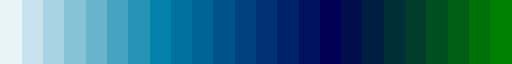

In [9]:
def create_discrete_colormap(cmap, num_colors):
    cmap_continuous = plt.cm.get_cmap(cmap)
    colors_continuous = cmap_continuous(np.linspace(0.03, 1, num_colors))  # Adjusted range, excluding white
    cmap_discrete = plt.matplotlib.colors.ListedColormap(colors_continuous)
    return cmap_discrete

# Example usage:
cmap_discrete_light = create_discrete_colormap("ocean_r", 24)
cmap_discrete_light

BAH
[ 9 10 11 12] <xarray.DataArray '__xarray_dataarray_variable__' ()>
array(281)
Coordinates:
    time     datetime64[ns] 2022-01-01
[19 20] <xarray.DataArray '__xarray_dataarray_variable__' ()>
array(146)
Coordinates:
    time     datetime64[ns] 2022-01-01
[49 50 51 52 53 54 55 56 57 58 59 60 61 62] <xarray.DataArray '__xarray_dataarray_variable__' ()>
array(586)
Coordinates:
    time     datetime64[ns] 2022-01-01
[69 70 71 72 73 74 75 76 77 78 79 80 81 82] <xarray.DataArray '__xarray_dataarray_variable__' ()>
array(558)
Coordinates:
    time     datetime64[ns] 2022-01-01
[119 120 121 122] <xarray.DataArray '__xarray_dataarray_variable__' ()>
array(28)
Coordinates:
    time     datetime64[ns] 2022-01-01
[129 130] <xarray.DataArray '__xarray_dataarray_variable__' ()>
array(1435)
Coordinates:
    time     datetime64[ns] 2022-01-01
[189 190] <xarray.DataArray '__xarray_dataarray_variable__' ()>
array(6)
Coordinates:
    time     datetime64[ns] 2022-01-01
AUS
[ 9 10 11 12] <xarray.DataA

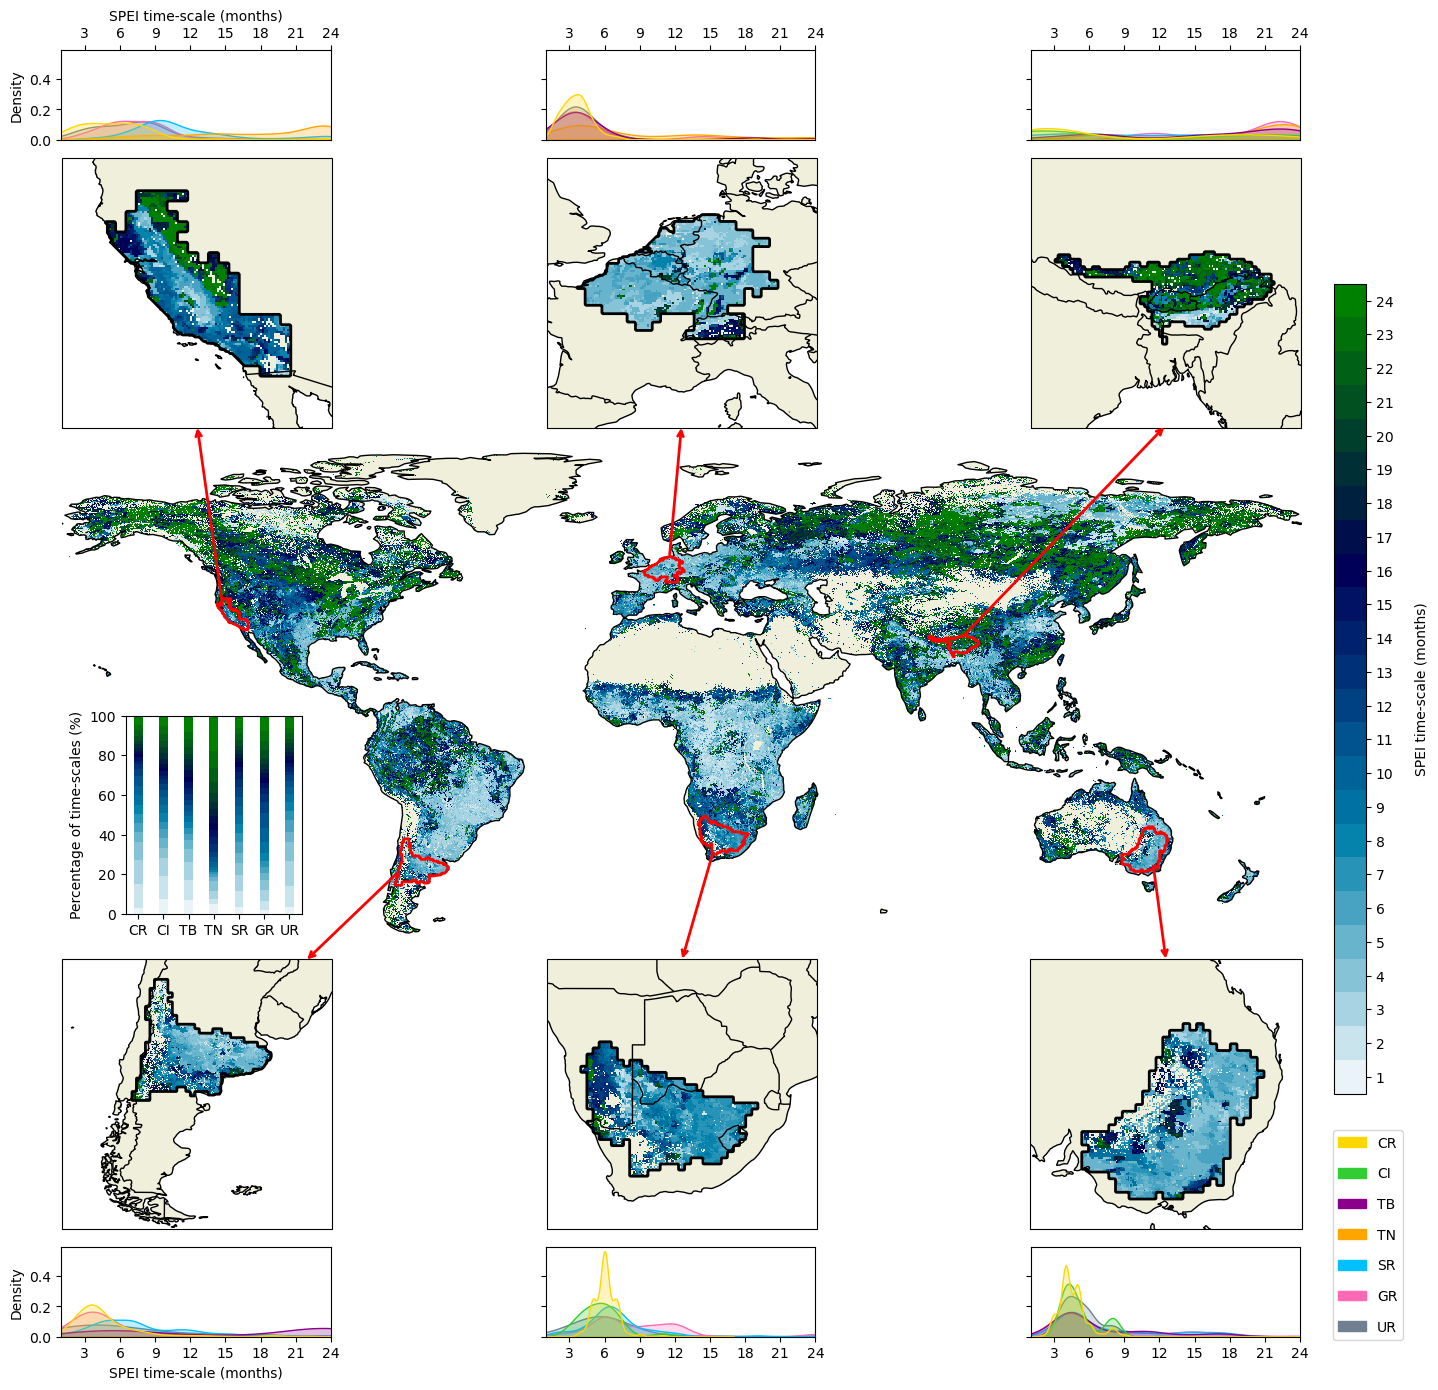

In [15]:
input_data = SPEI_timescales_
style = 'white'
resolution = '0_1_degrees'
discrete_cmap = cmap_discrete_light
vmin = 0
vmax = 24
cbar_label = 'SPEI time-scale (months)'
extend = 'neither'
focus_regions = True
contour_color_region = 'black'
contour_color_global = 'red'
arrowcolor = 'red'
xmin_dist = 1
xmax_dist = 24
xticks = [3,6,9,12,15,18,21,24]
ymin_dist = 0
ymax_dist = 0.595
yticks = [0,0.2,0.4,0.6]
vline = False
plot = 'extreme_based'
bin_linspace = None
cmap_discrete_combined = None
dir = '/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/'
title = 'extreme_based_method'
discrete_colors = False
savefig = True


plot_worldmap_with_regions_with_dist_percentage(input_data, style, resolution, discrete_cmap, vmin, vmax, cbar_label, extend, focus_regions, contour_color_region, contour_color_global, arrowcolor, xmin_dist, xmax_dist, xticks, ymin_dist, ymax_dist, yticks, vline, plot, bin_linspace, cmap_discrete_combined, dir, title, savefig, discrete_colors)

## Calculate the SPEI-grid data during MYD and ND

In [11]:
SPEI_grid_MYD, SPEI_grid_nd = SPEI_MYD(resolution = "0_1_degrees")

## Number of MYDs

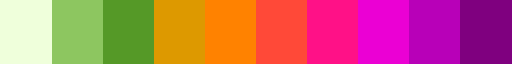

In [47]:
colors = ['#0000FF', '#008000', '#FFA500', '#FF00FF', '#800080']  # Blue, Green, Orange, Pink, Purple
colors = [(1.0, 0.8, 0.6, 1.0),  # Light orange
        (0.6, 0.8, 0.4, 1.0),  # Light green
        (0.2, 0.6, 0.2, 1.0),  # Dark green
        (0.8, 0.6, 0.0, 1.0),  # Medium orange
        (1.0, 0.6, 0.0, 1.0),  # Orange
        (1.0, 0.4, 0.0, 1.0),  # Dark orange
        (1.0, 0.2, 0.4, 1.0),  # Light red
        (1.0, 0.0, 0.6, 1.0),  # Medium red
        (0.9, 0.0, 0.9, 1.0),  # Light purple
        (0.7, 0.0, 0.7, 1.0),  # Medium purple
        (0.5, 0.0, 0.5, 1.0)]  # Dark purple
# Get the color of cfeature.LAND
land_color = cfeature.COLORS['land']

# Convert the color to RGB format (from hex)
land_rgb = mcolors.to_rgb(land_color)

# Increase the green component slightly and adjust red and blue if needed
adjusted_land_rgb = (
    min(land_rgb[0] * 1.0, 1.0),  # Slightly decrease red
    min(land_rgb[1] * 1.3, 1.0),  # Slightly increase green
    min(land_rgb[2] * 1.0, 1.0)   # Slightly decrease blue
)

# Convert the adjusted RGB back to a hex color
adjusted_land_color = mcolors.to_hex(adjusted_land_rgb)

# Define your list of colors, starting with the adjusted land color
interpolated_colors = mcolors.LinearSegmentedColormap.from_list('custom_colormap', [adjusted_land_color] + colors[1:], N=10)

# Get the discrete colors
discrete_colors = [interpolated_colors(i) for i in range(10)]

# Define labels for each category
labels = ["{}".format(i) for i in range(10)]

# Create a custom discrete colormap
cmap = mcolors.ListedColormap(discrete_colors)

# Define the boundaries of each category
boundaries = np.linspace(-0.5, 9.5, 11)

# Create a norm instance to map values to colors
norm = mcolors.BoundaryNorm(boundaries, cmap.N)
cmap

In [48]:
num_droughts_per_cell = count_droughts_for_each_cell(SPEI_grid_MYD)

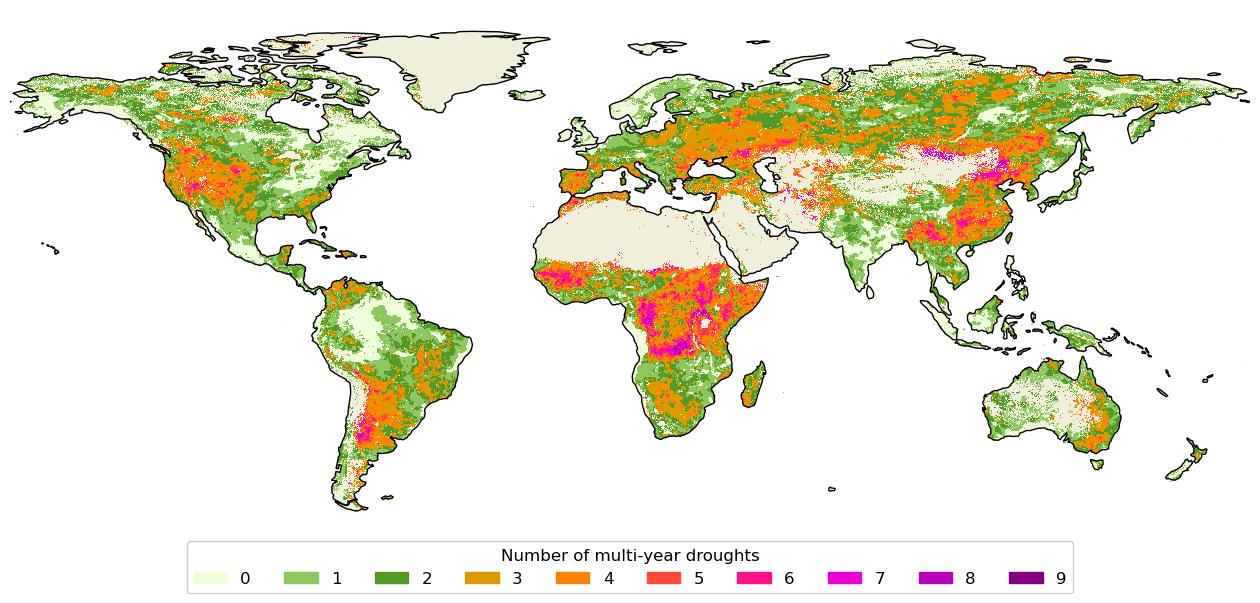

In [49]:
input_data = num_droughts_per_cell
style = 'white'
resolution = '0_1_degrees'
discrete_cmap = cmap
vmin = 0
vmax = 9
cbar_label = 'Number of MYDs'
extend = 'neither'
plot = 'number_of_MYDs'


####Not relevant without focus regions####
focus_regions = False
contour_color_region = 'black'
contour_color_global = 'black'
arrowcolor = 'black'
xmin_dist = 0
xmax_dist = 9
xticks = None
ymin_dist = 0
ymax_dist = 0.65
yticks = [0,0.2,0.4,0.6]
vline = False
##########################################

bin_linspace = np.linspace(0, 9, 10)
cmap_discrete_combined = cmap
dir = '/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/'
title = 'number_of_MYDs_no_inset'
discrete_colors = discrete_colors
savefig = True

plot_worldmap_with_regions_with_dist_percentage(input_data, style, resolution, discrete_cmap, vmin, vmax, cbar_label, extend, focus_regions, contour_color_region, contour_color_global, arrowcolor, xmin_dist, xmax_dist, xticks, ymin_dist, ymax_dist, yticks, vline, plot, bin_linspace, cmap_discrete_combined, dir, title, savefig, discrete_colors)

## Mean number of months per MYD

/tmp/ipykernel_119413/3834892147.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_continuous = plt.cm.get_cmap(cmap)


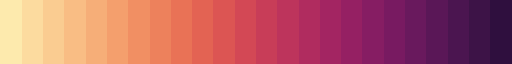

In [58]:
def create_discrete_colormap(cmap, num_colors):
    cmap_continuous = plt.cm.get_cmap(cmap)
    colors_continuous = cmap_continuous(np.linspace(0.01, 1, num_colors))
    cmap_discrete = plt.matplotlib.colors.ListedColormap(colors_continuous)
    return cmap_discrete

cmap_discrete = create_discrete_colormap(cmaps.matter, 24)
cmap_discrete

/tmp/ipykernel_119413/3834892147.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_continuous = plt.cm.get_cmap(cmap)


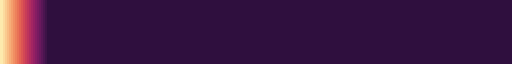

In [59]:
# Create the first part of the colormap with 30 colors
cmap_discrete_first = create_discrete_colormap(cmaps.matter, 24)

# Get the last color of the first colormap
last_color = cmap_discrete_first.colors[-1]

# Create the second part of the colormap with the last color repeated 23 times
cmap_discrete_second = plt.matplotlib.colors.ListedColormap([last_color] * 229)

# Combine both parts to get the final colormap
combined_colors = np.vstack((cmap_discrete_first.colors, cmap_discrete_second.colors))
cmap_discrete_combined = plt.matplotlib.colors.ListedColormap(combined_colors)

cmap_discrete_combined

In [60]:
months_no_desert_no_snow_no_spare = count_months(SPEI_grid_MYD)
#num_droughts_per_cell = count_droughts_for_each_cell(SPEI_grid_MYD)
months_per_myd = months_no_desert_no_snow_no_spare/num_droughts_per_cell
months_per_myd

<xarray.DataArray '__xarray_dataarray_variable__' (lat: 1800, lon: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 -90.0 -89.9 -89.8 -89.7 -89.6 ... 89.6 89.7 89.8 89.9

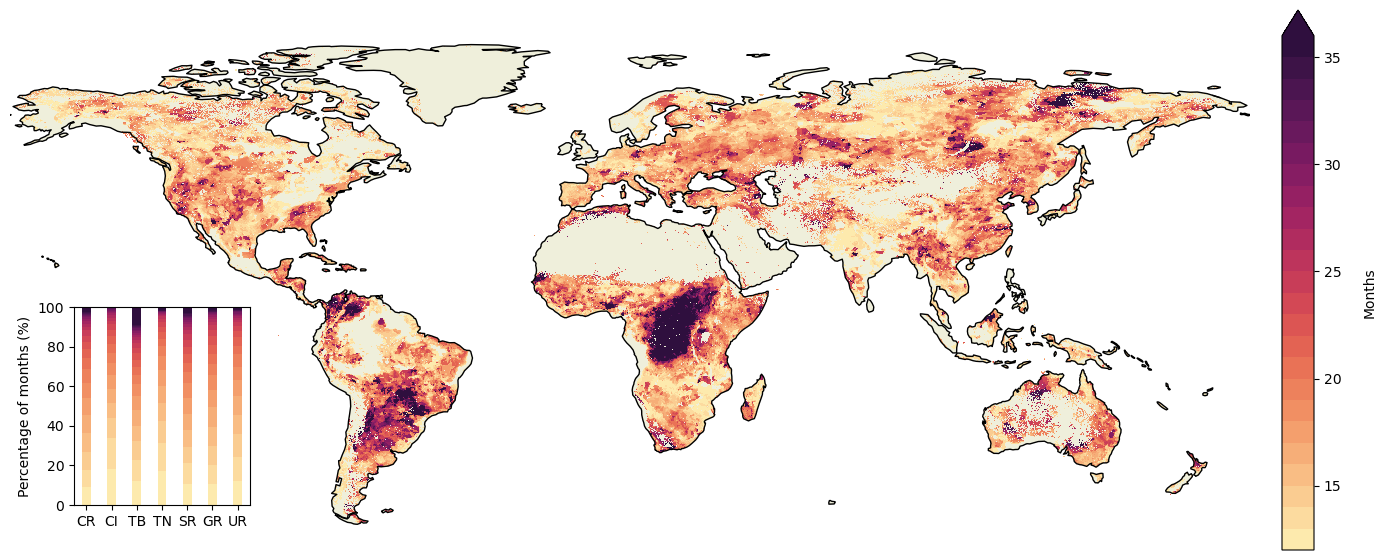

In [53]:
input_data = months_per_myd
style = 'white'
resolution = '0_1_degrees'
discrete_cmap = cmap_discrete
vmin = 12
vmax = 36
cbar_label = 'Months'
extend = 'max'
plot = "mean_months_per_MYD"

####Not relevant without focus regions####
focus_regions = False
contour_color_region = 'black'
contour_color_global = 'black'
arrowcolor = 'black'
xmin_dist = 0
xmax_dist = 9
xticks = None
ymin_dist = 0
ymax_dist = 0.65
yticks = [0,0.2,0.4,0.6]
vline = False
##########################################

bin_linspace = np.linspace(12, 265, 254)
cmap_discrete_combined = cmap_discrete_combined
dir = '/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/'
title = 'mean_months_per_MYD'
savefig = True

plot_worldmap_with_regions_with_dist_percentage(input_data, style, resolution, discrete_cmap, vmin, vmax, cbar_label, extend, focus_regions, contour_color_region, contour_color_global, arrowcolor, xmin_dist, xmax_dist, xticks, ymin_dist, ymax_dist, yticks, vline, plot, bin_linspace, cmap_discrete_combined, dir, title, savefig, discrete_colors)

## Drought intensity

/tmp/ipykernel_119413/1518375612.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd_r', num_colors)


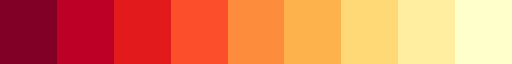

In [54]:
# Number of discrete colors to use
num_colors = 9

# Get the YlOrRd colormap
cmap = plt.cm.get_cmap('YlOrRd_r', num_colors)


# Create a discrete colormap
discrete_cmap = cmap(np.linspace(0, 1, num_colors))

# Create a ListedColormap object
discrete_cmap = ListedColormap(discrete_cmap)
discrete_cmap

In [55]:
SPEI_grid_MYD_timemean = SPEI_grid_MYD.mean("time")
SPEI_grid_MYD_timemean

<xarray.DataArray '__xarray_dataarray_variable__' (lat: 1800, lon: 3600)>
array([[-1.43680597, -1.43680597, -1.43680597, ..., -1.43680597,
        -1.43680597, -1.43680597],
       [-1.42844167, -1.42833697, -1.42837387, ..., -1.4274941 ,
        -1.42828621, -1.42816793],
       [-1.39891638, -1.39889408, -1.39957781, ..., -1.40014815,
        -1.39991767, -1.39831244],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 -90.0 -89.9 -89.8 -89.7 -89.6 ... 89.6 89.7 89.8 89.9

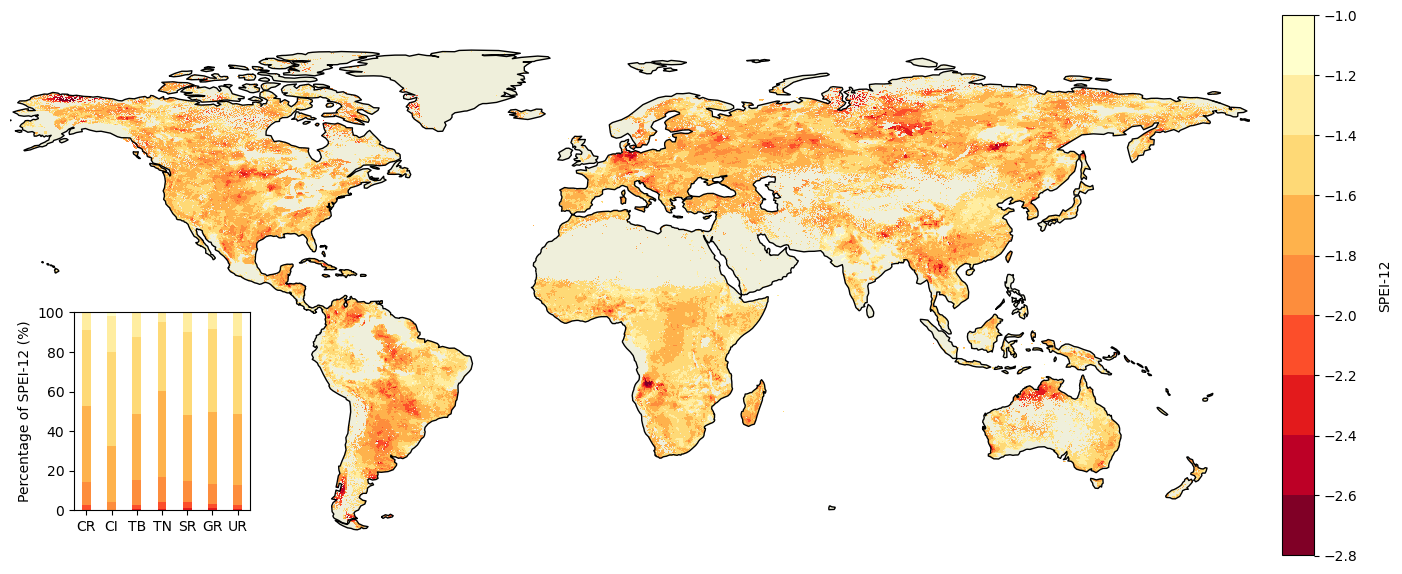

In [56]:
input_data = SPEI_grid_MYD_timemean
style = 'white'
resolution = '0_1_degrees'
discrete_cmap = discrete_cmap
vmin = -2.8
vmax = -1
cbar_label = 'SPEI-12'
extend = 'neither'
plot = 'MYD_intensity'

####Not relevant without focus regions####
focus_regions = False
contour_color_region = 'black'
contour_color_global = 'black'
arrowcolor = 'black'
xmin_dist = 0
xmax_dist = 9
xticks = None
ymin_dist = 0
ymax_dist = 0.65
yticks = [0,0.2,0.4,0.6]
vline = False
##########################################

bin_linspace = np.linspace(-2.8, -1, 10)
cmap_discrete_combined = discrete_cmap
dir = '/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/'
title = 'MYD_intensity'
savefig = True

plot_worldmap_with_regions_with_dist_percentage(input_data, style, resolution, discrete_cmap, vmin, vmax, cbar_label, extend, focus_regions, contour_color_region, contour_color_global, arrowcolor, xmin_dist, xmax_dist, xticks, ymin_dist, ymax_dist, yticks, vline, plot, bin_linspace, cmap_discrete_combined, dir, title, savefig, discrete_colors)

## Mean EVI during MYD

/tmp/ipykernel_184182/1932787800.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmaps.vegetation_ClarkU, num_colors)


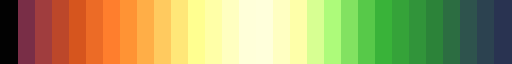

In [12]:
# Number of discrete colors to use
num_colors = 30

# Get the vegetation_ClarkU colormap
cmap = plt.cm.get_cmap(cmaps.vegetation_ClarkU, num_colors)

# Define brightness change parameters
outer_brightness = 0.01
middle_brightness = 0.4

# Calculate brightness changes
brightness_changes = np.linspace(outer_brightness, middle_brightness, num_colors // 2)

# Modify the colors to make yellow and green lighter
colors = cmap(np.linspace(0, 1, num_colors))
colors[:num_colors // 2] += brightness_changes[:, np.newaxis]  # Increase brightness for yellow
colors[num_colors // 2:] += brightness_changes[::-1][:, np.newaxis]  # Increase brightness for green

# Ensure colors stay within the valid RGBA range of 0 to 1
colors = colors.clip(0.0, 1.0)

# Create a ListedColormap object
discrete_cmap = ListedColormap(colors)
discrete_cmap


/tmp/ipykernel_184182/3369397003.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmaps.vegetation_ClarkU, num_colors)


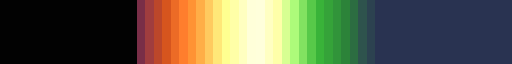

In [13]:
# Number of discrete colors to use
num_colors = 30

# Get the vegetation_ClarkU colormap
cmap = plt.cm.get_cmap(cmaps.vegetation_ClarkU, num_colors)

# Define brightness change parameters
outer_brightness = 0.01
middle_brightness = 0.4

# Calculate brightness changes
brightness_changes = np.linspace(outer_brightness, middle_brightness, num_colors // 2)

# Modify the colors to make yellow and green lighter
colors = cmap(np.linspace(0, 1, num_colors))
colors[:num_colors // 2] += brightness_changes[:, np.newaxis]  # Increase brightness for yellow
colors[num_colors // 2:] += brightness_changes[::-1][:, np.newaxis]  # Increase brightness for green

# Ensure colors stay within the valid RGBA range of 0 to 1
colors = colors.clip(0.0, 1.0)

# Create a ListedColormap object
cmap_discrete_first = ListedColormap(colors)


# Get the first color of the first colormap
first_color = cmap_discrete_first.colors[0]
# Get the last color of the first colormap
last_color = cmap_discrete_first.colors[-1]

# Create the first part of the colormap with the first color repeated 15 times
cmap_discrete_first_part = plt.matplotlib.colors.ListedColormap([first_color] * 15)
# Create the second part of the colormap with the last color repeated 15 times
cmap_discrete_second_part = plt.matplotlib.colors.ListedColormap([last_color] * 15)

# Combine both parts to get the final colormap
combined_colors = np.vstack((cmap_discrete_first_part.colors, cmap_discrete_first.colors, cmap_discrete_second_part.colors))
cmap_discrete_combined = plt.matplotlib.colors.ListedColormap(combined_colors)

cmap_discrete_combined


In [14]:
EVI_st_an_MYD_mean = EVI_MYDs_timemean(SPEI_grid_MYD)

BAH
[ 9 10 11 12] <xarray.DataArray 'EVI' ()>
array(279)
Coordinates:
    time     datetime64[ns] 2022-01-01
[19 20] <xarray.DataArray 'EVI' ()>
array(144)
Coordinates:
    time     datetime64[ns] 2022-01-01
[49 50 51 52 53 54 55 56 57 58 59 60 61 62] <xarray.DataArray 'EVI' ()>
array(581)
Coordinates:
    time     datetime64[ns] 2022-01-01
[69 70 71 72 73 74 75 76 77 78 79 80 81 82] <xarray.DataArray 'EVI' ()>
array(546)
Coordinates:
    time     datetime64[ns] 2022-01-01
[119 120 121 122] <xarray.DataArray 'EVI' ()>
array(28)
Coordinates:
    time     datetime64[ns] 2022-01-01
[129 130] <xarray.DataArray 'EVI' ()>
array(1232)
Coordinates:
    time     datetime64[ns] 2022-01-01
[189 190] <xarray.DataArray 'EVI' ()>
array(6)
Coordinates:
    time     datetime64[ns] 2022-01-01
AUS
[ 9 10 11 12] <xarray.DataArray 'EVI' ()>
array(2115)
Coordinates:
    time     datetime64[ns] 2022-01-01
[19 20] <xarray.DataArray 'EVI' ()>
array(104)
Coordinates:
    time     datetime64[ns] 2022-01-01
[49 

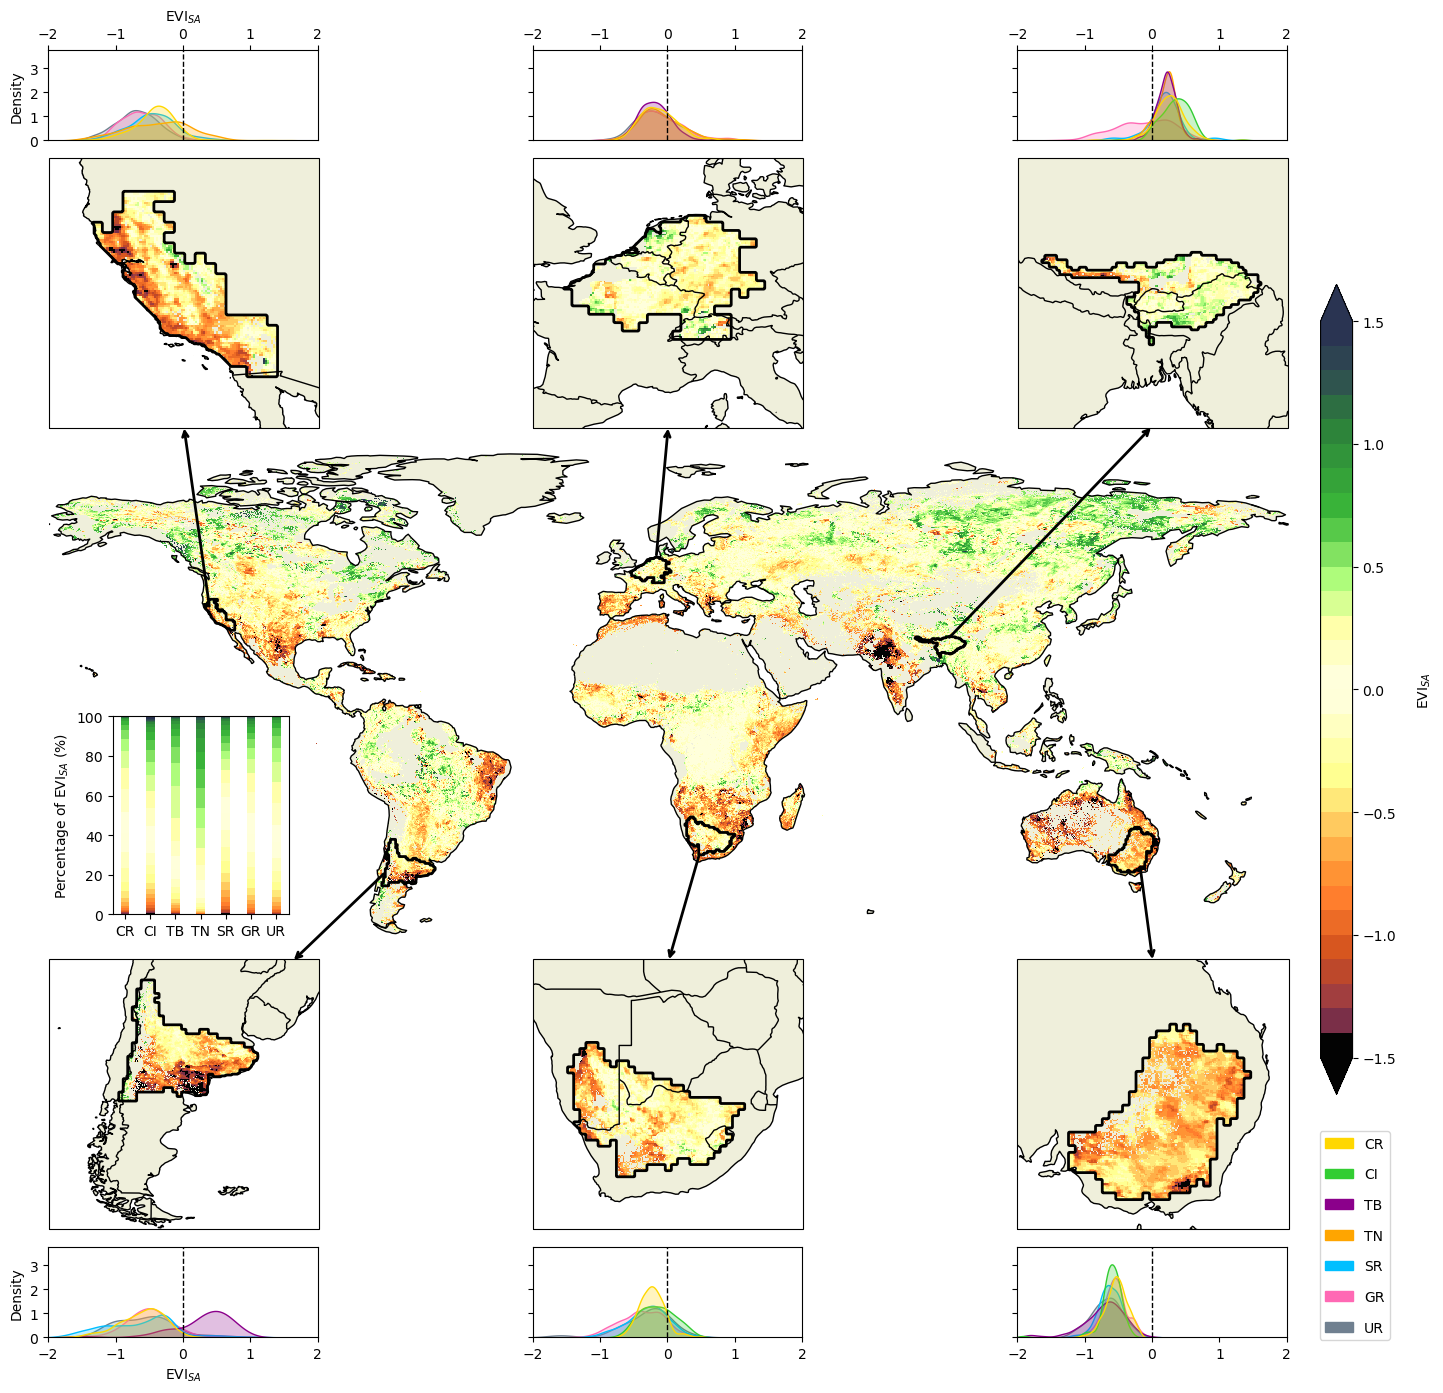

In [21]:
input_data = EVI_st_an_MYD_mean
style = 'white'
resolution = '0_1_degrees'
discrete_cmap = discrete_cmap
vmin = -1.5
vmax = 1.5
#cbar_label = 'Standardized EVI anomaly'
cbar_label = r'EVI$_{SA}$'
extend = 'both'
plot = 'MYD_mean_EVI'


focus_regions = True
contour_color_region = 'black'
contour_color_global = 'black'
arrowcolor = 'black'
xmin_dist = -2
xmax_dist = 2
xticks = [-2,-1,0,1,2]
ymin_dist = 0
ymax_dist = 3.75
yticks = [0,1,2,3]
vline = True


bin_linspace = np.linspace(-3.3, 3.3, 67)
cmap_discrete_combined = cmap_discrete_combined
dir = '/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/'
title = 'MYD_mean_EVI'
savefig = True

plot_worldmap_with_regions_with_dist_percentage(input_data, style, resolution, discrete_cmap, vmin, vmax, cbar_label, extend, focus_regions, contour_color_region, contour_color_global, arrowcolor, xmin_dist, xmax_dist, xticks, ymin_dist, ymax_dist, yticks, vline, plot, bin_linspace, cmap_discrete_combined, dir, title, savefig, discrete_colors)

## Mean EVI during ND

In [15]:
EVI_st_an_nd_mean = EVI_MYDs_timemean(SPEI_grid_nd)

BAH
[ 9 10 11 12] <xarray.DataArray 'EVI' ()>
array(281)
Coordinates:
    time     datetime64[ns] 2022-01-01
[19 20] <xarray.DataArray 'EVI' ()>
array(146)
Coordinates:
    time     datetime64[ns] 2022-01-01
[49 50 51 52 53 54 55 56 57 58 59 60 61 62] <xarray.DataArray 'EVI' ()>
array(584)
Coordinates:
    time     datetime64[ns] 2022-01-01
[69 70 71 72 73 74 75 76 77 78 79 80 81 82] <xarray.DataArray 'EVI' ()>
array(558)
Coordinates:
    time     datetime64[ns] 2022-01-01
[119 120 121 122] <xarray.DataArray 'EVI' ()>
array(28)
Coordinates:
    time     datetime64[ns] 2022-01-01
[129 130] <xarray.DataArray 'EVI' ()>
array(1433)
Coordinates:
    time     datetime64[ns] 2022-01-01
[189 190] <xarray.DataArray 'EVI' ()>
array(6)
Coordinates:
    time     datetime64[ns] 2022-01-01
AUS
[ 9 10 11 12] <xarray.DataArray 'EVI' ()>
array(2115)
Coordinates:
    time     datetime64[ns] 2022-01-01
[19 20] <xarray.DataArray 'EVI' ()>
array(104)
Coordinates:
    time     datetime64[ns] 2022-01-01
[49 

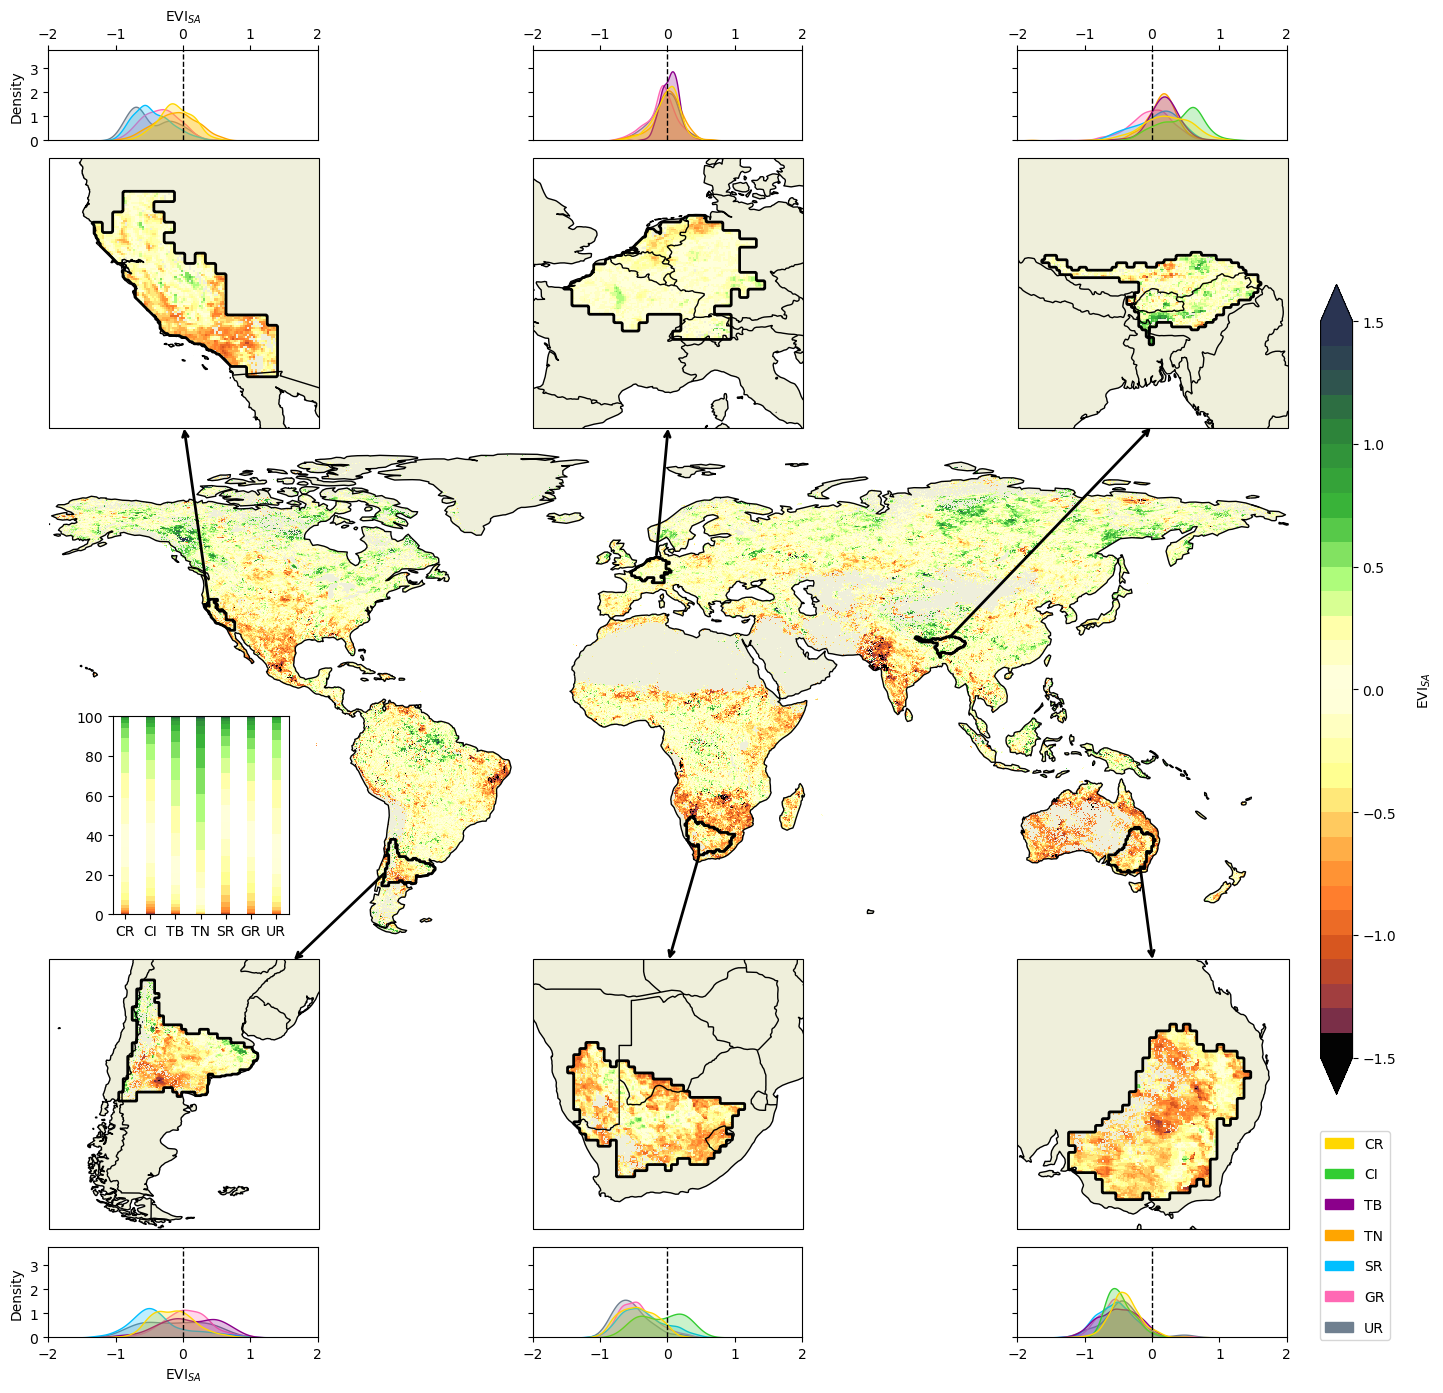

In [23]:
input_data = EVI_st_an_nd_mean
style = 'white'
resolution = '0_1_degrees'
discrete_cmap = discrete_cmap
vmin = -1.5
vmax = 1.5
#cbar_label = 'Standardized EVI anomaly'
cbar_label = r'EVI$_{SA}$'
extend = 'both'
plot = None


focus_regions = True
contour_color_region = 'black'
contour_color_global = 'black'
arrowcolor = 'black'
xmin_dist = -2
xmax_dist = 2
xticks = [-2,-1,0,1,2]
ymin_dist = 0
ymax_dist = 3.75
yticks = [0,1,2,3]
vline = True


bin_linspace = np.linspace(-3.3, 3.3, 67)
cmap_discrete_combined = cmap_discrete_combined
dir = '/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/'
title = 'ND_mean_EVI'
savefig = True

plot_worldmap_with_regions_with_dist_percentage(input_data, style, resolution, discrete_cmap, vmin, vmax, cbar_label, extend, focus_regions, contour_color_region, contour_color_global, arrowcolor, xmin_dist, xmax_dist, xticks, ymin_dist, ymax_dist, yticks, vline, plot, bin_linspace, cmap_discrete_combined, dir, title, savefig, discrete_colors)

## Difference mean EVI MYD and ND

/tmp/ipykernel_184182/2970407926.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmaps.curl_r, num_colors)


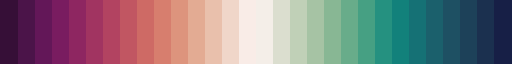

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Number of discrete colors to use
num_colors = 30

# Get the vegetation_ClarkU colormap
cmap = plt.cm.get_cmap(cmaps.curl_r, num_colors)

# Define brightness change parameters
outer_brightness = 0.01
middle_brightness = 0.001

# Calculate brightness changes
brightness_changes = np.linspace(outer_brightness, middle_brightness, num_colors // 2)

# Modify the colors to make yellow and green lighter
colors = cmap(np.linspace(0, 1, num_colors))
colors[:num_colors // 2] += brightness_changes[:, np.newaxis]  # Increase brightness for yellow
colors[num_colors // 2:] += brightness_changes[::-1][:, np.newaxis]  # Increase brightness for green

# Ensure colors stay within the valid RGBA range of 0 to 1
colors = colors.clip(0.0, 1.0)

# Create a ListedColormap object
discrete_cmap = ListedColormap(colors)
discrete_cmap


/tmp/ipykernel_119413/2367484729.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmaps.curl_r, num_colors)


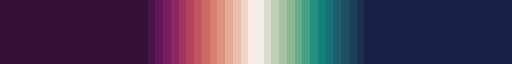

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Number of discrete colors to use
num_colors = 30

# Get the vegetation_ClarkU colormap
cmap = plt.cm.get_cmap(cmaps.curl_r, num_colors)

# Define brightness change parameters
outer_brightness = 0.01
middle_brightness = 0.001

# Calculate brightness changes
brightness_changes = np.linspace(outer_brightness, middle_brightness, num_colors // 2)

# Modify the colors to make yellow and green lighter
colors = cmap(np.linspace(0, 1, num_colors))
colors[:num_colors // 2] += brightness_changes[:, np.newaxis]  # Increase brightness for yellow
colors[num_colors // 2:] += brightness_changes[::-1][:, np.newaxis]  # Increase brightness for green

# Ensure colors stay within the valid RGBA range of 0 to 1
colors = colors.clip(0.0, 1.0)

# Create a ListedColormap object
cmap_discrete_first = ListedColormap(colors)


# Get the first color of the first colormap
first_color = cmap_discrete_first.colors[0]
# Get the last color of the first colormap
last_color = cmap_discrete_first.colors[-1]

# Create the first part of the colormap with the first color repeated 15 times
cmap_discrete_first_part = plt.matplotlib.colors.ListedColormap([first_color] * 18)
# Create the second part of the colormap with the last color repeated 15 times
cmap_discrete_second_part = plt.matplotlib.colors.ListedColormap([last_color] * 18)

# Combine both parts to get the final colormap
combined_colors = np.vstack((cmap_discrete_first_part.colors, cmap_discrete_first.colors, cmap_discrete_second_part.colors))
cmap_discrete_combined = plt.matplotlib.colors.ListedColormap(combined_colors)

cmap_discrete_combined


In [20]:
# EVI_st_an_MYD_mean = EVI_MYDs_timemean(SPEI_grid_MYD)
# EVI_st_an_nd_mean = EVI_MYDs_timemean(SPEI_grid_nd)

diff = EVI_st_an_MYD_mean - EVI_st_an_nd_mean

/tmp/ipykernel_119413/758908328.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('curl_r', num_colors)


BAH
[ 9 10 11 12] <xarray.DataArray 'EVI' ()>
array(279)
Coordinates:
    time     datetime64[ns] 2022-01-01
[19 20] <xarray.DataArray 'EVI' ()>
array(144)
Coordinates:
    time     datetime64[ns] 2022-01-01
[49 50 51 52 53 54 55 56 57 58 59 60 61 62] <xarray.DataArray 'EVI' ()>
array(579)
Coordinates:
    time     datetime64[ns] 2022-01-01
[69 70 71 72 73 74 75 76 77 78 79 80 81 82] <xarray.DataArray 'EVI' ()>
array(546)
Coordinates:
    time     datetime64[ns] 2022-01-01
[119 120 121 122] <xarray.DataArray 'EVI' ()>
array(28)
Coordinates:
    time     datetime64[ns] 2022-01-01
[129 130] <xarray.DataArray 'EVI' ()>
array(1230)
Coordinates:
    time     datetime64[ns] 2022-01-01
[189 190] <xarray.DataArray 'EVI' ()>
array(6)
Coordinates:
    time     datetime64[ns] 2022-01-01
AUS
[ 9 10 11 12] <xarray.DataArray 'EVI' ()>
array(2115)
Coordinates:
    time     datetime64[ns] 2022-01-01
[19 20] <xarray.DataArray 'EVI' ()>
array(104)
Coordinates:
    time     datetime64[ns] 2022-01-01
[49 

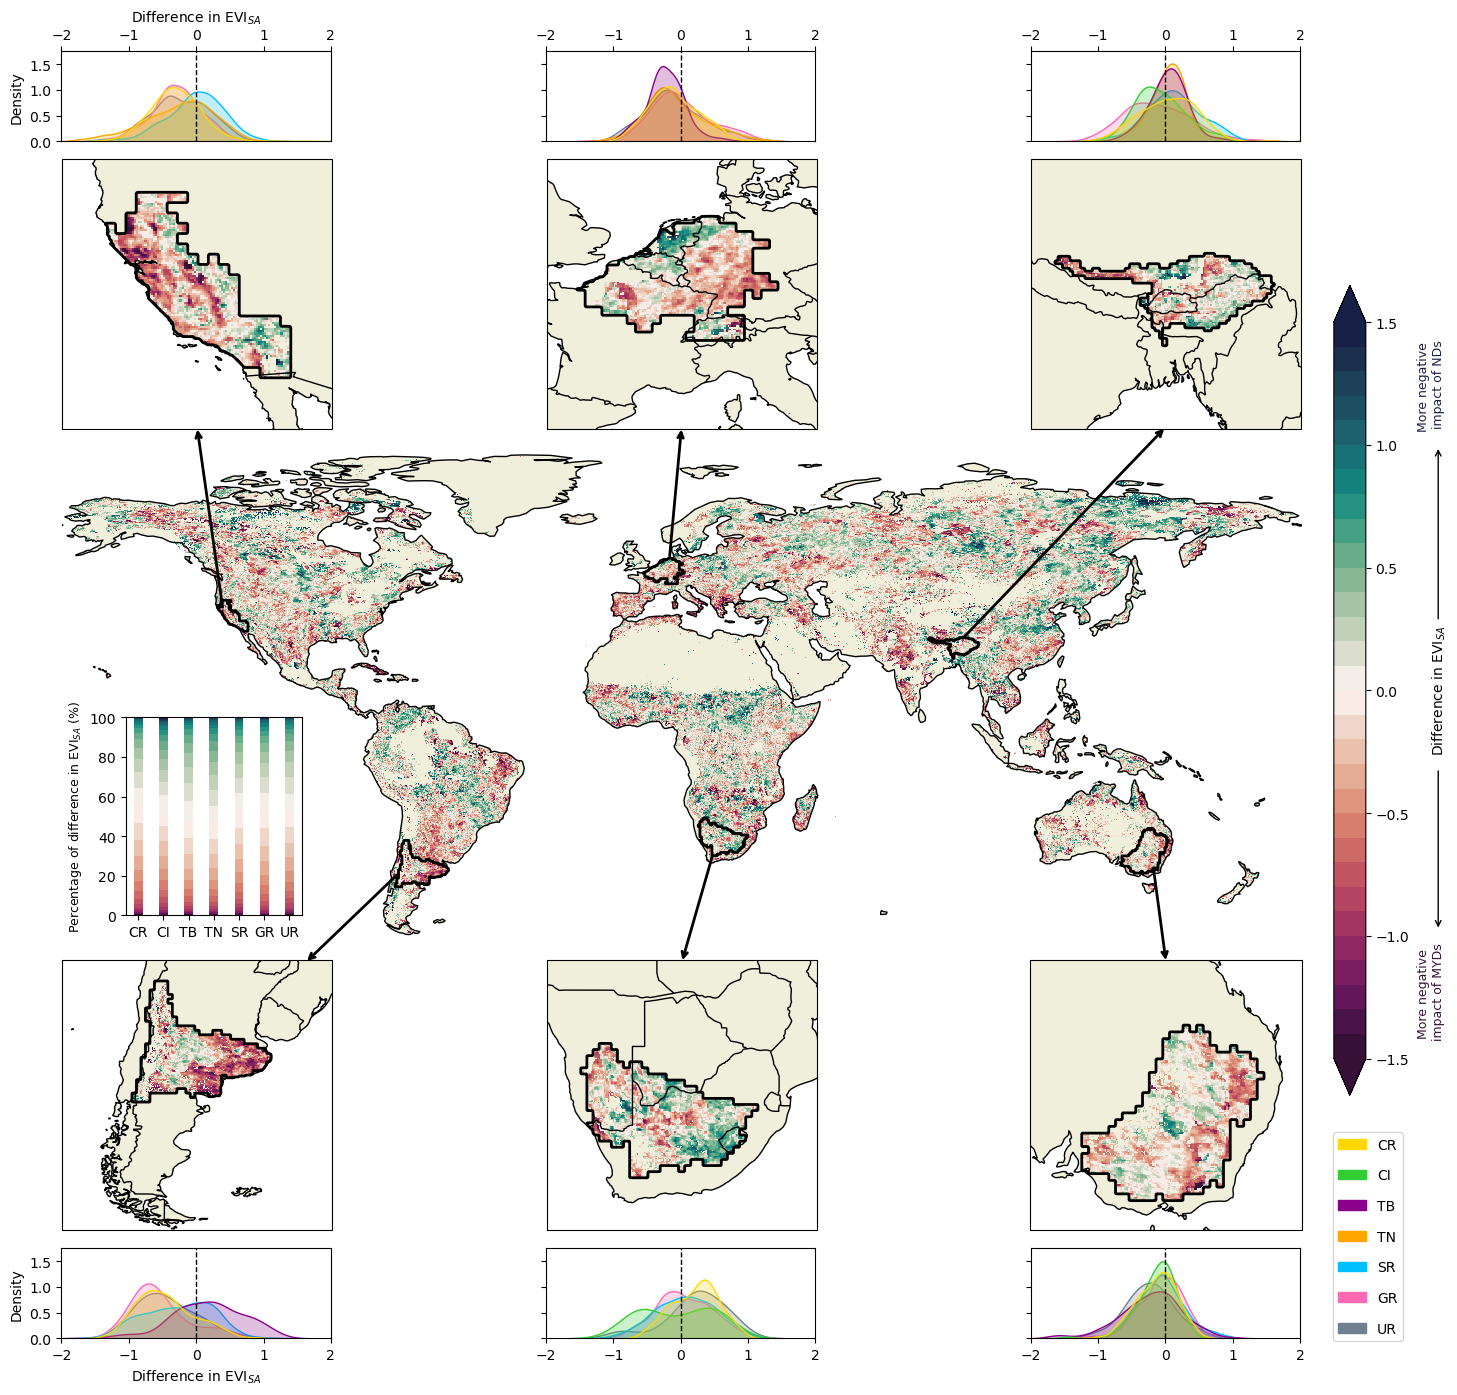

In [27]:
input_data = diff
style = 'white'
resolution = '0_1_degrees'
discrete_cmap = discrete_cmap
vmin = -1.5
vmax = 1.5
cbar_label = r'Difference in EVI$_{SA}$' #'MYD - ND'
extend = 'both'
plot = 'MYD_ND_EVI_difference'


focus_regions = True
contour_color_region = 'black'
contour_color_global = 'black'
arrowcolor = 'black'
xmin_dist = -2
xmax_dist = 2
xticks = [-2,-1,0,1,2]
ymin_dist = 0
ymax_dist = 1.75
yticks = [0,0.5,1,1.5]
vline = True


bin_linspace = np.linspace(-3.3, 3.3, 67)
cmap_discrete_combined = cmap_discrete_combined
dir = '/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/'
title = 'MYD_ND_EVI_difference_v2'
discrete_colors = None
savefig = True

plot_worldmap_with_regions_with_dist_percentage(input_data, style, resolution, discrete_cmap, vmin, vmax, cbar_label, extend, focus_regions, contour_color_region, contour_color_global, arrowcolor, xmin_dist, xmax_dist, xticks, ymin_dist, ymax_dist, yticks, vline, plot, bin_linspace, cmap_discrete_combined, dir, title, savefig, discrete_colors)

## Sum EVI during MYD

/tmp/ipykernel_119413/1973926940.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmaps.vegetation_ClarkU, num_colors)


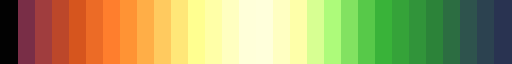

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Number of discrete colors to use
num_colors = 30

# Get the vegetation_ClarkU colormap
cmap = plt.cm.get_cmap(cmaps.vegetation_ClarkU, num_colors)

# Define brightness change parameters
outer_brightness = 0.01
middle_brightness = 0.4

# Calculate brightness changes
brightness_changes = np.linspace(outer_brightness, middle_brightness, num_colors // 2)

# Modify the colors to make yellow and green lighter
colors = cmap(np.linspace(0, 1, num_colors))
colors[:num_colors // 2] += brightness_changes[:, np.newaxis]  # Increase brightness for yellow
colors[num_colors // 2:] += brightness_changes[::-1][:, np.newaxis]  # Increase brightness for green

# Ensure colors stay within the valid RGBA range of 0 to 1
colors = colors.clip(0.0, 1.0)

# Create a ListedColormap object
discrete_cmap = ListedColormap(colors)
discrete_cmap


/tmp/ipykernel_119413/4157657509.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmaps.vegetation_ClarkU, num_colors)


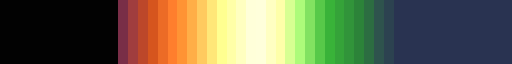

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Number of discrete colors to use
num_colors = 30

# Get the vegetation_ClarkU colormap
cmap = plt.cm.get_cmap(cmaps.vegetation_ClarkU, num_colors)

# Define brightness change parameters
outer_brightness = 0.01
middle_brightness = 0.4

# Calculate brightness changes
brightness_changes = np.linspace(outer_brightness, middle_brightness, num_colors // 2)

# Modify the colors to make yellow and green lighter
colors = cmap(np.linspace(0, 1, num_colors))
colors[:num_colors // 2] += brightness_changes[:, np.newaxis]  # Increase brightness for yellow
colors[num_colors // 2:] += brightness_changes[::-1][:, np.newaxis]  # Increase brightness for green

# Ensure colors stay within the valid RGBA range of 0 to 1
colors = colors.clip(0.0, 1.0)

# Create a ListedColormap object
cmap_discrete_first = ListedColormap(colors)


# Get the first color of the first colormap
first_color = cmap_discrete_first.colors[0]
# Get the last color of the first colormap
last_color = cmap_discrete_first.colors[-1]

# Create the first part of the colormap with the first color repeated 15 times
cmap_discrete_first_part = plt.matplotlib.colors.ListedColormap([first_color] * 11)
# Create the second part of the colormap with the last color repeated 15 times
cmap_discrete_second_part = plt.matplotlib.colors.ListedColormap([last_color] * 11)

# Combine both parts to get the final colormap
combined_colors = np.vstack((cmap_discrete_first_part.colors, cmap_discrete_first.colors, cmap_discrete_second_part.colors))
cmap_discrete_combined = plt.matplotlib.colors.ListedColormap(combined_colors)

cmap_discrete_combined


In [30]:
EVI_st_an_MYD_sum = EVI_MYDs_sum(SPEI_grid_MYD)

In [13]:
EVI_st_an_MYD_sum.min()

<xarray.DataArray 'EVI' ()>
array(-94.18029773)

In [14]:
EVI_st_an_MYD_sum.max()

<xarray.DataArray 'EVI' ()>
array(103.53452155)

BAH
[ 9 10 11 12] <xarray.DataArray 'EVI' ()>
array(281)
Coordinates:
    time     datetime64[ns] 2022-01-01
[19 20] <xarray.DataArray 'EVI' ()>
array(146)
Coordinates:
    time     datetime64[ns] 2022-01-01
[49 50 51 52 53 54 55 56 57 58 59 60 61 62] <xarray.DataArray 'EVI' ()>
array(586)
Coordinates:
    time     datetime64[ns] 2022-01-01
[69 70 71 72 73 74 75 76 77 78 79 80 81 82] <xarray.DataArray 'EVI' ()>
array(558)
Coordinates:
    time     datetime64[ns] 2022-01-01
[119 120 121 122] <xarray.DataArray 'EVI' ()>
array(28)
Coordinates:
    time     datetime64[ns] 2022-01-01
[129 130] <xarray.DataArray 'EVI' ()>
array(1435)
Coordinates:
    time     datetime64[ns] 2022-01-01
[189 190] <xarray.DataArray 'EVI' ()>
array(6)
Coordinates:
    time     datetime64[ns] 2022-01-01
AUS
[ 9 10 11 12] <xarray.DataArray 'EVI' ()>
array(2116)
Coordinates:
    time     datetime64[ns] 2022-01-01
[19 20] <xarray.DataArray 'EVI' ()>
array(105)
Coordinates:
    time     datetime64[ns] 2022-01-01
[49 

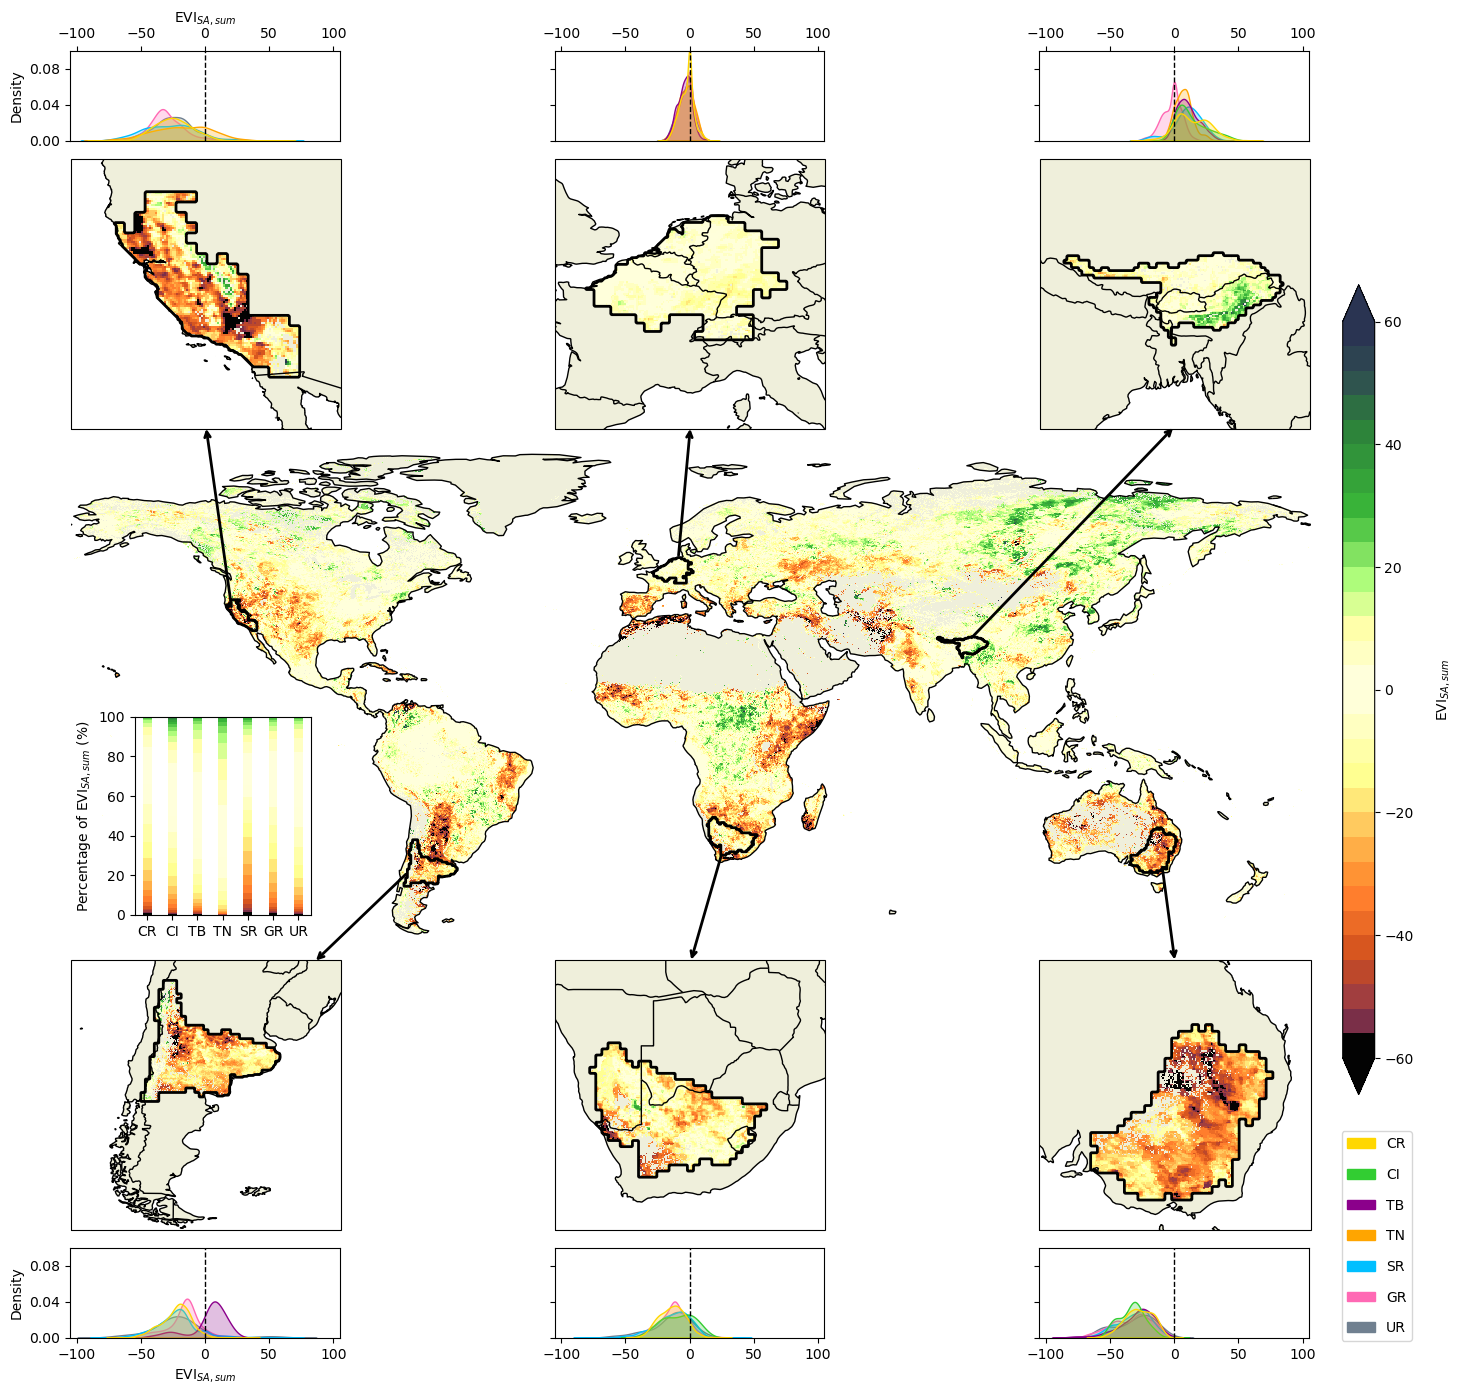

In [31]:
input_data = EVI_st_an_MYD_sum
style = 'white'
resolution = '0_1_degrees'
discrete_cmap = discrete_cmap
vmin = -60
vmax = 60
#cbar_label = 'Standardized EVI anomaly (sum)'
cbar_label = r'EVI$_{SA,sum}$'
extend = 'both'
plot = 'MYD_sum_EVI'


focus_regions = True
contour_color_region = 'black'
contour_color_global = 'black'
arrowcolor = 'black'
xmin_dist = -105
xmax_dist = 105
xticks = [-100,-50,0,50,100]
ymin_dist = 0
ymax_dist = 0.1
yticks = [0,0.04,0.08]
vline = True


bin_linspace = np.linspace(-104, 104, 53)
cmap_discrete_combined = cmap_discrete_combined
dir = '/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/'
title = 'MYD_sum_EVI'
discrete_colors = None
savefig = True

plot_worldmap_with_regions_with_dist_percentage(input_data, style, resolution, discrete_cmap, vmin, vmax, cbar_label, extend, focus_regions, contour_color_region, contour_color_global, arrowcolor, xmin_dist, xmax_dist, xticks, ymin_dist, ymax_dist, yticks, vline, plot, bin_linspace, cmap_discrete_combined, dir, title, savefig, discrete_colors)

## Sum EVI during ND

In [32]:
EVI_st_an_ND_sum = EVI_MYDs_sum(SPEI_grid_nd) 

BAH
[ 9 10 11 12] <xarray.DataArray 'EVI' ()>
array(281)
Coordinates:
    time     datetime64[ns] 2022-01-01
[19 20] <xarray.DataArray 'EVI' ()>
array(146)
Coordinates:
    time     datetime64[ns] 2022-01-01
[49 50 51 52 53 54 55 56 57 58 59 60 61 62] <xarray.DataArray 'EVI' ()>
array(586)
Coordinates:
    time     datetime64[ns] 2022-01-01
[69 70 71 72 73 74 75 76 77 78 79 80 81 82] <xarray.DataArray 'EVI' ()>
array(558)
Coordinates:
    time     datetime64[ns] 2022-01-01
[119 120 121 122] <xarray.DataArray 'EVI' ()>
array(28)
Coordinates:
    time     datetime64[ns] 2022-01-01
[129 130] <xarray.DataArray 'EVI' ()>
array(1435)
Coordinates:
    time     datetime64[ns] 2022-01-01
[189 190] <xarray.DataArray 'EVI' ()>
array(6)
Coordinates:
    time     datetime64[ns] 2022-01-01
AUS
[ 9 10 11 12] <xarray.DataArray 'EVI' ()>
array(2116)
Coordinates:
    time     datetime64[ns] 2022-01-01
[19 20] <xarray.DataArray 'EVI' ()>
array(105)
Coordinates:
    time     datetime64[ns] 2022-01-01
[49 

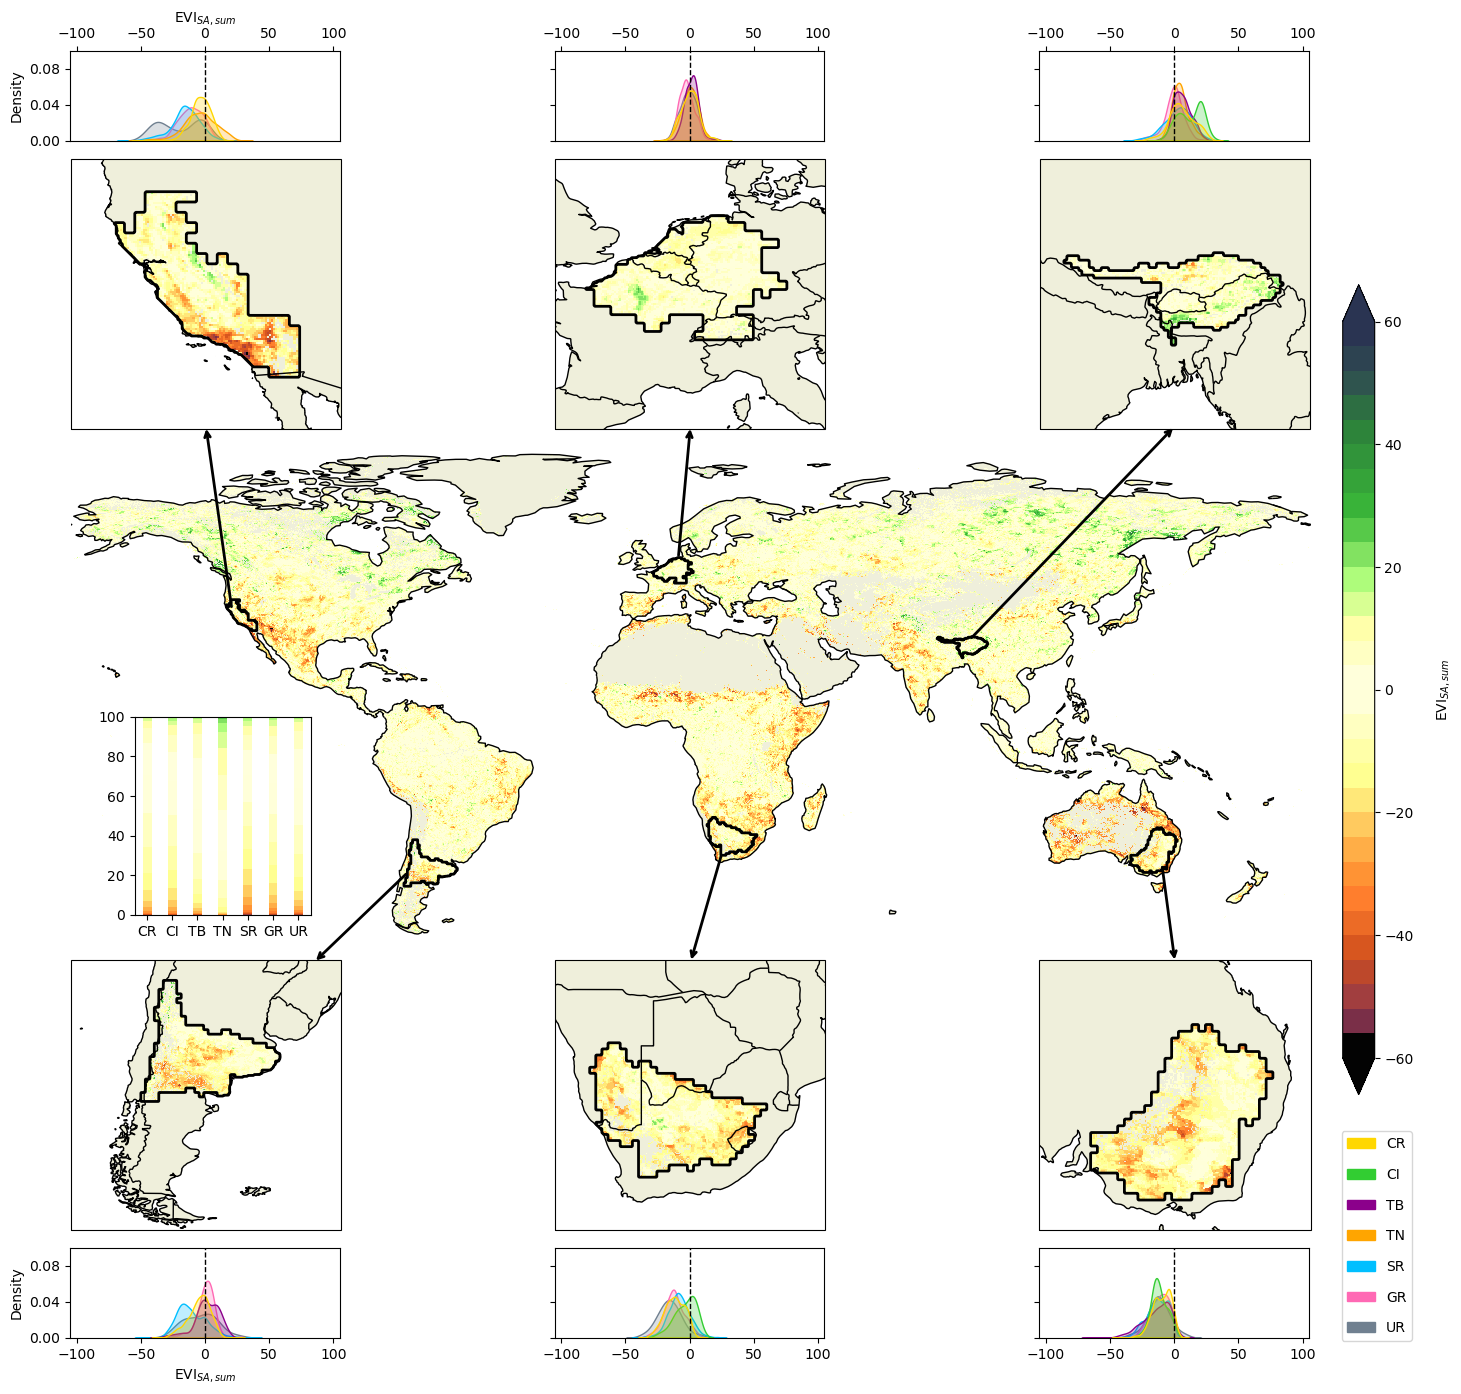

In [33]:
input_data = EVI_st_an_ND_sum
style = 'white'
resolution = '0_1_degrees'
discrete_cmap = discrete_cmap
vmin = -60
vmax = 60
#cbar_label = 'Standardized EVI anomaly (sum)'
cbar_label = r'EVI$_{SA,sum}$'
extend = 'both'
plot = None


focus_regions = True
contour_color_region = 'black'
contour_color_global = 'black'
arrowcolor = 'black'
xmin_dist = -105
xmax_dist = 105
xticks = [-100,-50,0,50,100]
ymin_dist = 0
ymax_dist = 0.1
yticks = [0,0.04,0.08]
vline = True


bin_linspace = np.linspace(-104, 104, 53)
cmap_discrete_combined = cmap_discrete_combined
dir = '/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/'
title = 'ND_sum_EVI'
discrete_colors = None
savefig = True

plot_worldmap_with_regions_with_dist_percentage(input_data, style, resolution, discrete_cmap, vmin, vmax, cbar_label, extend, focus_regions, contour_color_region, contour_color_global, arrowcolor, xmin_dist, xmax_dist, xticks, ymin_dist, ymax_dist, yticks, vline, plot, bin_linspace, cmap_discrete_combined, dir, title, savefig, discrete_colors)

## Difference sum MYD and ND

/tmp/ipykernel_119413/618899600.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmaps.curl_r, num_colors)


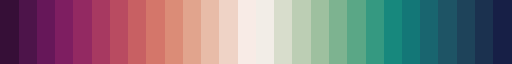

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Number of discrete colors to use
num_colors = 28

# Get the vegetation_ClarkU colormap
cmap = plt.cm.get_cmap(cmaps.curl_r, num_colors)

# Define brightness change parameters
outer_brightness = 0.01
middle_brightness = 0.001

# Calculate brightness changes
brightness_changes = np.linspace(outer_brightness, middle_brightness, num_colors // 2)

# Modify the colors to make yellow and green lighter
colors = cmap(np.linspace(0, 1, num_colors))
colors[:num_colors // 2] += brightness_changes[:, np.newaxis]  # Increase brightness for yellow
colors[num_colors // 2:] += brightness_changes[::-1][:, np.newaxis]  # Increase brightness for green

# Ensure colors stay within the valid RGBA range of 0 to 1
colors = colors.clip(0.0, 1.0)

# Create a ListedColormap object
discrete_cmap = ListedColormap(colors)
discrete_cmap


/tmp/ipykernel_119413/3201512589.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmaps.curl_r, num_colors)


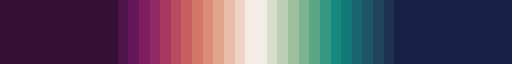

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Number of discrete colors to use
num_colors = 28

# Get the vegetation_ClarkU colormap
cmap = plt.cm.get_cmap(cmaps.curl_r, num_colors)

# Define brightness change parameters
outer_brightness = 0.01
middle_brightness = 0.001

# Calculate brightness changes
brightness_changes = np.linspace(outer_brightness, middle_brightness, num_colors // 2)

# Modify the colors to make yellow and green lighter
colors = cmap(np.linspace(0, 1, num_colors))
colors[:num_colors // 2] += brightness_changes[:, np.newaxis]  # Increase brightness for yellow
colors[num_colors // 2:] += brightness_changes[::-1][:, np.newaxis]  # Increase brightness for green

# Ensure colors stay within the valid RGBA range of 0 to 1
colors = colors.clip(0.0, 1.0)

# Create a ListedColormap object
cmap_discrete_first = ListedColormap(colors)


# Get the first color of the first colormap
first_color = cmap_discrete_first.colors[0]
# Get the last color of the first colormap
last_color = cmap_discrete_first.colors[-1]

# Create the first part of the colormap with the first color repeated 15 times
cmap_discrete_first_part = plt.matplotlib.colors.ListedColormap([first_color] * 10)
# Create the second part of the colormap with the last color repeated 15 times
cmap_discrete_second_part = plt.matplotlib.colors.ListedColormap([last_color] * 10)

# Combine both parts to get the final colormap
combined_colors = np.vstack((cmap_discrete_first_part.colors, cmap_discrete_first.colors, cmap_discrete_second_part.colors))
cmap_discrete_combined = plt.matplotlib.colors.ListedColormap(combined_colors)

cmap_discrete_combined


In [36]:
# EVI_st_an_MYD_sum = EVI_MYDs_sum(SPEI_grid_MYD)
# EVI_st_an_ND_sum = EVI_MYDs_sum(SPEI_grid_nd) 
diff = EVI_st_an_MYD_sum - EVI_st_an_ND_sum

/tmp/ipykernel_119413/758908328.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('curl_r', num_colors)


BAH
[ 9 10 11 12] <xarray.DataArray 'EVI' ()>
array(281)
Coordinates:
    time     datetime64[ns] 2022-01-01
[19 20] <xarray.DataArray 'EVI' ()>
array(146)
Coordinates:
    time     datetime64[ns] 2022-01-01
[49 50 51 52 53 54 55 56 57 58 59 60 61 62] <xarray.DataArray 'EVI' ()>
array(586)
Coordinates:
    time     datetime64[ns] 2022-01-01
[69 70 71 72 73 74 75 76 77 78 79 80 81 82] <xarray.DataArray 'EVI' ()>
array(558)
Coordinates:
    time     datetime64[ns] 2022-01-01
[119 120 121 122] <xarray.DataArray 'EVI' ()>
array(28)
Coordinates:
    time     datetime64[ns] 2022-01-01
[129 130] <xarray.DataArray 'EVI' ()>
array(1435)
Coordinates:
    time     datetime64[ns] 2022-01-01
[189 190] <xarray.DataArray 'EVI' ()>
array(6)
Coordinates:
    time     datetime64[ns] 2022-01-01
AUS
[ 9 10 11 12] <xarray.DataArray 'EVI' ()>
array(2116)
Coordinates:
    time     datetime64[ns] 2022-01-01
[19 20] <xarray.DataArray 'EVI' ()>
array(105)
Coordinates:
    time     datetime64[ns] 2022-01-01
[49 

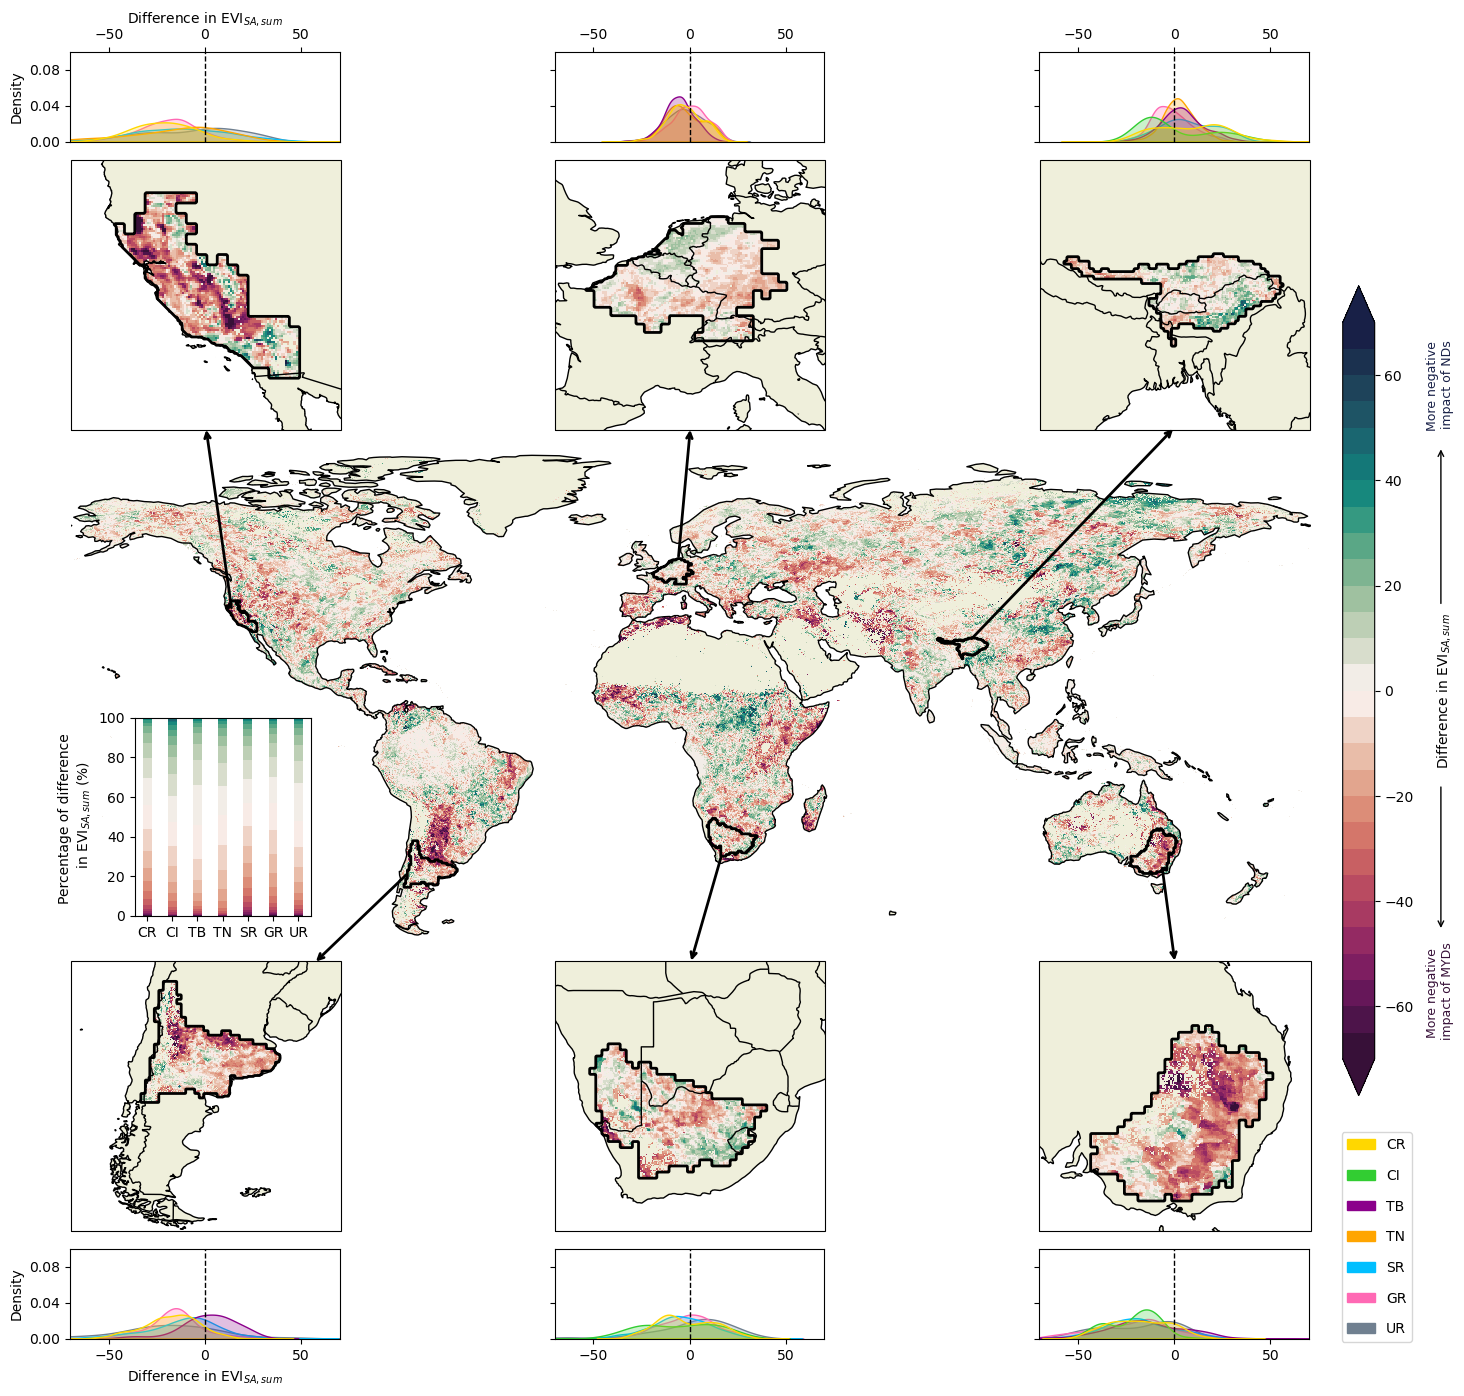

In [37]:
input_data = diff
style = 'white'
resolution = '0_1_degrees'
discrete_cmap = discrete_cmap
vmin = -70
vmax = 70
cbar_label = r'Difference in EVI$_{SA,sum}$' #'MYD - ND'
extend = 'both'
plot = 'MYD_ND_EVI_difference_sum'


focus_regions = True
contour_color_region = 'black'
contour_color_global = 'black'
arrowcolor = 'black'
xmin_dist = -70
xmax_dist = 70
xticks = [-50,0,50]
ymin_dist = 0
ymax_dist = 0.1
yticks = [0,0.04,0.08]
vline = True


bin_linspace = np.linspace(-120, 120, 49)
cmap_discrete_combined = cmap_discrete_combined
dir = '/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/'
title = 'MYD_ND_EVI_difference_sum_v2'
savefig = True

plot_worldmap_with_regions_with_dist_percentage(input_data, style, resolution, discrete_cmap, vmin, vmax, cbar_label, extend, focus_regions, contour_color_region, contour_color_global, arrowcolor, xmin_dist, xmax_dist, xticks, ymin_dist, ymax_dist, yticks, vline, plot, bin_linspace, cmap_discrete_combined, dir, title, savefig, discrete_colors)

## Land cover type

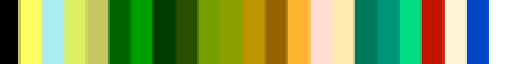

In [19]:
colors = [
    (0, 0, 0),            # No Data
    (1.0, 1.0, 0.392),    # Cropland, rainfed
    (0.667, 0.941, 0.941),# Cropland, irrigated or post-flooding
    (0.863, 0.941, 0.392),# Mosaic cropland / natural vegetation
    (0.784, 0.784, 0.392),# Mosaic natural vegetation / cropland
    (0, 0.392, 0),        # Tree cover, broadleaved, evergreen, closed to open
    (0, 0.627, 0),        # Tree cover, broadleaved, deciduous, closed to open
    (0, 0.235, 0),        # Tree cover, needleleaved, evergreen, closed to open
    (0.157, 0.314, 0),    # Tree cover, needleleaved, deciduous, closed to open
    (0.471, 0.627, 0),    # Tree cover, mixed leaf type (broadleaved and needleleaved)
    (0.549, 0.627, 0),    # Mosaic tree and shrub / herbaceous cover
    (0.745, 0.588, 0),    # Mosaic herbaceous cover / tree and shrub
    (0.588, 0.392, 0),    # Shrubland
    (1.0, 0.706, 0.196),  # Grassland
    (1.0, 0.863, 0.824),  # Lichens and mosses
    (1.0, 0.922, 0.686),  # Sparse vegetation (tree, shrub, herbaceous cover)
    (0, 0.471, 0.353),    # Tree cover, flooded, fresh or brackish water
    (0, 0.588, 0.471),    # Tree cover, flooded, saline water
    (0, 0.863, 0.51),     # Shrub or herbaceous cover, flooded, fresh/saline/brackish water
    (0.761, 0.078, 0), # Urban areas
    (1.0, 0.961, 0.843),    # Bare areas
    (0, 0.275, 0.784),  # Water bodies
    (1, 1, 1),    # Permanent snow and ice
]

color_ranges = [(0,8), (8, 18), (18, 28), (28, 38), (38, 48), 
                (48, 58), (58, 68), (68, 78), (78, 88), 
                (88, 98), (98, 108), (108, 118), (118, 128), (128, 138),
                (138, 148), (148, 158), (158, 168), (168,178), (178,188),
                (188,198), (198,208), (208,218), (218,228)]

labels = ["No data", "Cropland, rainfed", "Cropland, irrigated or post-flooding",
          "Mosaic cropland / natural vegetation", "Mosaic natural vegetation / cropland",
          "Tree cover, broadleaved, evergreen", "Tree cover, broadleaved, deciduous",
          "Tree cover, needleleaved, evergreen", "Tree cover, needleleaved, deciduous",
          "Tree cover, mixed leaf type", "Mosaic tree and shrub / herbaceous cover",
          "Mosaic herbaceous cover / tree and shrub", "Shrubland", "Grassland",
          "Lichens and mosses", "Sparse vegetation", "Tree cover, flooded, fresh or brackish water",
          "Tree cover, flooded, saline water", "Shrub or herbaceous cover, flooded",
          "Urban areas", "Bare areas", "Water bodies", "Permanent snow and ice"]

# Create colormap
def create_cmap(colors, ranges):
    n = len(ranges)
    cmap_colors = []
    for i in range(n):
        start, end = ranges[i]
        for j in range(start, end + 1):
            cmap_colors.append(colors[i])
    return LinearSegmentedColormap.from_list(f'custom_cmap', cmap_colors, N=max([end for start, end in ranges]) + 1)

cmap = create_cmap(colors, color_ranges)
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]

cmap

In [6]:
lc = xr.open_dataset("/scratch/ruiij001/Data/Landcover/newest/regrid/C3S-LC-L4-LCCS-Map-0_1_degrees-P1Y-2022-v2.1.1.nc").lccs_class.sel(time = "2022-01-01")

In [21]:
def plot_worldmap(lc, style, resolution, focus_regions, savefig = False):
    
    if style == "black":
        plt.style.use('dark_background')
    if style == "white":
        plt.style.use('default')

    # Create the plot
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=11)}, figsize=(16, 9))
    ax.axis('off')
    # Assuming 'number_no_desert' is your data variable
    
    im = lc.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(),cmap=cmap, vmin = 0, vmax = 228)
    ax.set_title("", color='black')  
    
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)

    # Customize legend based on style
    if style == "black":
        legend = plt.legend(handles=legend_patches, title='Landcover type', loc='upper left', bbox_to_anchor=(1, 1))
        #legend = plt.legend(handles=legend_patches, title='Number of multi-year droughts', title_fontsize='large', loc='upper center', bbox_to_anchor=(0.62, 0.1), ncol=len(discrete_colors),prop={'size':9})
        frame = legend.get_frame()
        frame.set_edgecolor('white')  # Set legend box edge color to white
        frame.set_facecolor('black')  # Set legend box face color to black
        frame.set_alpha(1)
        legend.get_title().set_color('white')  # Set legend title color to white
        for text in legend.get_texts():
            text.set_color('white')  # Set legend text color to white
    elif style == "white":
        legend = plt.legend(handles=legend_patches, title='Landcover type', loc='upper left', bbox_to_anchor=(1, 1))
        #legend = plt.legend(handles=legend_patches, title='Number of multi-year droughts', title_fontsize='large', loc='upper center', bbox_to_anchor=(0.62, 0.1), ncol=len(discrete_colors),prop={'size':9})
        frame = legend.get_frame()
        frame.set_edgecolor('black')  # Set legend box edge color to black
        frame.set_facecolor('white')  # Set legend box face color to white
        frame.set_alpha(1)
        legend.get_title().set_color('black')  # Set legend title color to black
        for text in legend.get_texts():
            text.set_color('black')  # Set legend text color to black
    
    if focus_regions == True:
        # Include the focus regions into the plot
        regions = ["BAH","AUS","WEU","SA","ARG","CAL"]

        for region_name in regions:
            if region_name == "IND": 
                reg_lat = slice(7, 33)
                reg_lon = slice(68, 94)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_IND_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.6652
                bottom = 0.86
                inset_center_x = 0.7
                inset_center_y = 0.6
            elif region_name == "BAH": 
                reg_lat = slice(19,37) 
                reg_lon = slice(81,99)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_Brahmaputra_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.6652
                bottom = 0.86
                inset_center_x = 0.725
                inset_center_y = 0.668
            elif region_name == "AUS":
                reg_lat = slice(-39.9, -19.9)
                reg_lon = slice(135, 155)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_AUS_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.6652
                bottom = -0.17
                inset_center_x = 0.88
                inset_center_y = 0.30
            elif region_name == "WEU":
                reg_lat = slice(41, 57)
                reg_lon = slice(-2, 14)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_WEU_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.36235
                bottom = 0.86
                inset_center_x = 0.49
                inset_center_y = 0.795
            elif region_name == "SA":
                reg_lat = slice(-37, -15)
                reg_lon = slice(13, 35)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_SA_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.36235
                bottom = -0.17
                inset_center_x = 0.525
                inset_center_y = 0.325
            elif region_name == "ARG":
                reg_lat = slice(-56, -26)
                reg_lon = slice(-80, -50)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_ARG_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.0595
                bottom = -0.17
                inset_center_x = 0.272
                inset_center_y = 0.27
            elif region_name == "CAL":
                reg_lat = slice(30, 43)
                reg_lon = slice(-126, -113)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_CAL_0_1_degrees_new.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.0595
                bottom = 0.86
                inset_center_x = 0.129
                inset_center_y = 0.725

            # Where to put the subplot
            left, bottom, width, height = [left, bottom, 0.3, 0.3]
            ax_inset = fig.add_axes([left, bottom, width, height], projection=ccrs.PlateCarree())
            
            # Plot the focus regions
            lc_region = lc.sel(lon = reg_lon, lat = reg_lat).where(region_mask == 1)
            im = lc_region.plot(ax=ax_inset, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap, vmin = 0, vmax = 228)
            ax_inset.add_feature(cfeature.BORDERS)
            ax_inset.add_feature(cfeature.LAND)

            if style == "white":
                    ax_inset.add_feature(cfeature.COASTLINE)
                    ax_inset.set_title("", color='white') 
            else:
                ax_inset.set_title("", color='black') 

            # Load the land/sea mask so that the contours are not in the water
            lsm = xr.open_dataset("/scratch/ruiij001/Data/Masks/land_sea/land-sea-mask_0_1_degrees.nc").lsm.mean("time").sel(lat=reg_lat, lon=reg_lon)
            ax_inset.contour(region_mask.where(lsm > 0.5).lon, region_mask.where(lsm > 0.5).lat, np.isnan(region_mask.where(lsm > 0.5)), colors=contour_color_region, linewidths=2, transform=ccrs.PlateCarree())
            ax.contour(region_mask.where(lsm > 0.5).lon, region_mask.where(lsm > 0.5).lat, np.isnan(region_mask.where(lsm > 0.5)), colors=contour_color_global, linewidths=2, transform=ccrs.PlateCarree())
            
            # Draw arrows from the global plot to the focus region plots
            arrowprops = dict(arrowstyle="->", linewidth=2, color=arrowcolor)
            if bottom > 0.5:
                plt.annotate('', xy=(0.5, 0.01), xycoords=ax_inset.transAxes, xytext=(inset_center_x, inset_center_y), textcoords=ax.transAxes, arrowprops=arrowprops)
            else:
                plt.annotate('', xy=(0.5, 0.99), xycoords=ax_inset.transAxes, xytext=(inset_center_x, inset_center_y), textcoords=ax.transAxes, arrowprops=arrowprops)

    if savefig == True:
        if focus_regions == True:
            plt.savefig("/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/landcover_"+resolution+"_"+style+"_2022_global_with_focus_regions.png",dpi = 600, bbox_inches = "tight")
            plt.savefig("/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/landcover_"+resolution+"_"+style+"_2022_global_with_focus_regions.pdf", bbox_inches = "tight")
        else:
            plt.savefig("/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/landcover_"+resolution+"_"+style+"_2022_global.png",dpi = 600, bbox_inches = "tight")
            plt.savefig("/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/landcover_"+resolution+"_"+style+"_2022_global.pdf", bbox_inches = "tight")
    plt.show()


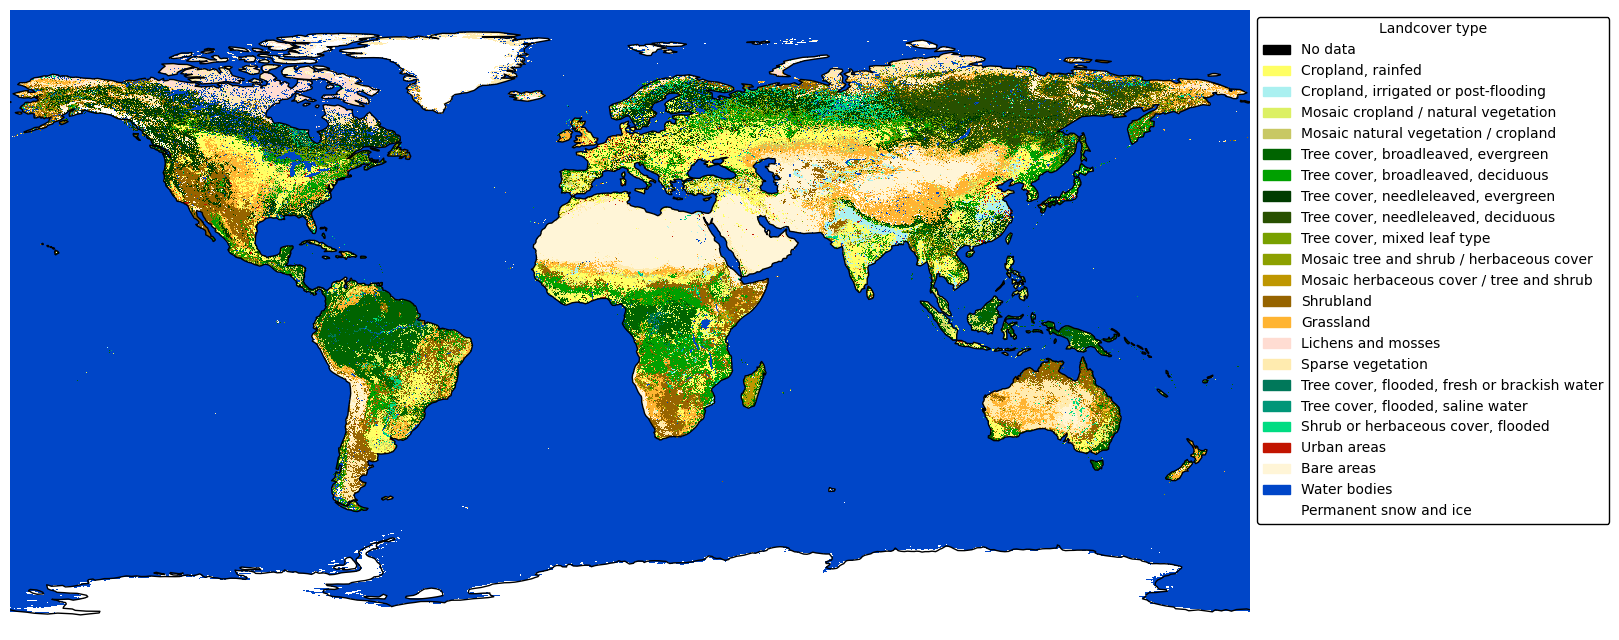

In [22]:
lc = lc
style = "white"
resolution = "0_1_degrees"
focus_regions = False
savefig = True

plot_worldmap(lc, style, resolution, focus_regions, savefig)

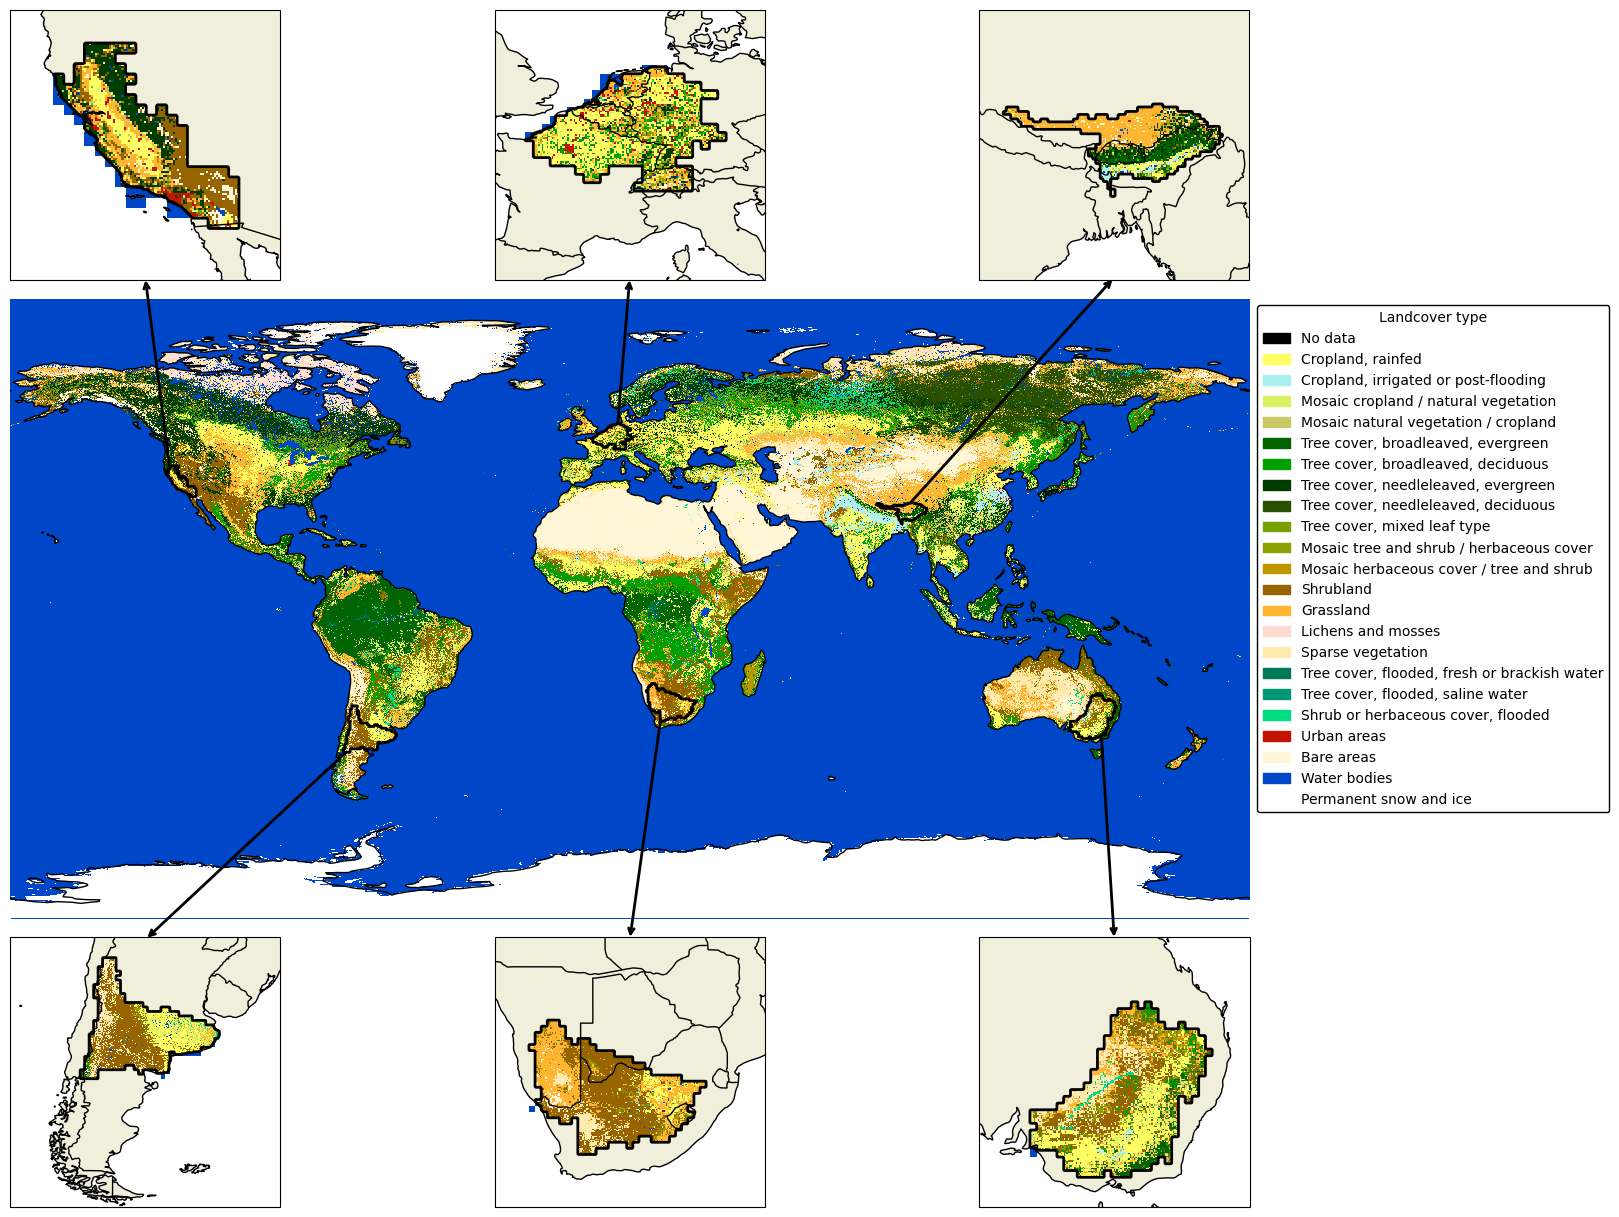

In [23]:
lc = lc
style = "white"
resolution = "0_1_degrees"
focus_regions = True
savefig = True

plot_worldmap(lc, style, resolution, focus_regions, savefig)

## Land cover type (only included vegetation types)

In [41]:
lc = xr.open_dataset("/scratch/ruiij001/Data/Landcover/newest/regrid/C3S-LC-L4-LCCS-Map-0_1_degrees-P1Y-2022-v2.1.1.nc").lccs_class.sel(time = "2022-01-01")

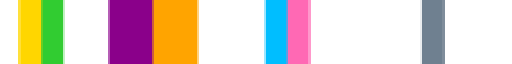

In [42]:
colors = [
    (1, 1, 1),            # No Data
    (1.0, 0.843, 0.0),    # Cropland, rainfed
    (0.196, 0.803, 0.196),# Cropland, irrigated or post-flooding
    (1, 1, 1),# Mosaic cropland / natural vegetation
    (1, 1, 1),# Mosaic natural vegetation / cropland
    (0.545, 0.0, 0.545),        # Tree cover, broadleaved, evergreen, closed to open
    (0.545, 0.0, 0.545),        # Tree cover, broadleaved, deciduous, closed to open
    (1.0, 0.647, 0.0),        # Tree cover, needleleaved, evergreen, closed to open
    (1.0, 0.647, 0.0),    # Tree cover, needleleaved, deciduous, closed to open
    (1, 1, 1),    # Tree cover, mixed leaf type (broadleaved and needleleaved)
    (1, 1, 1),    # Mosaic tree and shrub / herbaceous cover
    (1, 1, 1),    # Mosaic herbaceous cover / tree and shrub
    (0.0, 0.749, 1.0),    # Shrubland
    (1.0, 0.412, 0.706),  # Grassland
    (1, 1, 1),  # Lichens and mosses
    (1, 1, 1),  # Sparse vegetation (tree, shrub, herbaceous cover)
    (1, 1, 1),    # Tree cover, flooded, fresh or brackish water
    (1, 1, 1),    # Tree cover, flooded, saline water
    (1, 1, 1),     # Shrub or herbaceous cover, flooded, fresh/saline/brackish water
    (0.439, 0.502, 0.565), # Urban areas
    (1, 1, 1),    # Bare areas
    (1, 1, 1),  # Water bodies
    (1, 1, 1),    # Permanent snow and ice
]

color_ranges = [(0,8), (8, 18), (18, 28), (28, 38), (38, 48), 
                (48, 58), (58, 68), (68, 78), (78, 88), 
                (88, 98), (98, 108), (108, 118), (118, 128), (128, 138),
                (138, 148), (148, 158), (158, 168), (168,178), (178,188),
                (188,198), (198,208), (208,218), (218,228)]

labels = ["No data", "Cropland, rainfed", "Cropland, irrigated or post-flooding",
          "Mosaic cropland / natural vegetation", "Mosaic natural vegetation / cropland",
          "Tree cover, broadleaved, evergreen", "Tree cover, broadleaved, deciduous",
          "Tree cover, needleleaved, evergreen", "Tree cover, needleleaved, deciduous",
          "Tree cover, mixed leaf type", "Mosaic tree and shrub / herbaceous cover",
          "Mosaic herbaceous cover / tree and shrub", "Shrubland", "Grassland",
          "Lichens and mosses", "Sparse vegetation", "Tree cover, flooded, fresh or brackish water",
          "Tree cover, flooded, saline water", "Shrub or herbaceous cover, flooded",
          "Urban areas", "Bare areas", "Water bodies", "Permanent snow and ice"]

# Create colormap
def create_cmap(colors, ranges):
    n = len(ranges)
    cmap_colors = []
    for i in range(n):
        start, end = ranges[i]
        for j in range(start, end + 1):
            cmap_colors.append(colors[i])
    return LinearSegmentedColormap.from_list(f'custom_cmap', cmap_colors, N=max([end for start, end in ranges]) + 1)

cmap = create_cmap(colors, color_ranges)
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]

cmap

In [45]:
def plot_worldmap(lc, style, resolution, focus_regions, savefig = False):
    
    if style == "black":
        plt.style.use('dark_background')
    if style == "white":
        plt.style.use('default')

    # Define the types, titles, and colors
    cropland_rainfed = np.arange(9, 13)
    cropland_irrigated = np.arange(19, 21)
    broadleaved = np.arange(49, 63)
    needleleaved = np.arange(69, 83)
    shrubland = np.arange(119, 123)
    grassland = np.arange(129, 131)
    urban = np.arange(189, 191)

    types = [cropland_rainfed, cropland_irrigated, broadleaved, needleleaved, shrubland, grassland, urban]

    # Create the plot
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=11)}, figsize=(16, 9))
    ax.axis('off')
    # Assuming 'number_no_desert' is your data variable
    
    im = lc.sel(lat = slice(-60,90)).plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(),cmap=cmap, vmin = 0, vmax = 228)
    ax.set_title("", color='black')  
    
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)

    titles = ["Cropland, rainfed", "Cropland, irrigated", "Tree cover, broadleaved", "Tree cover, needleleaved", "Shrubland", "Grassland", "Urban areas"]
    titles_short = ["CR", "CI", "TB", "TN", "SR", "GR", "UR"]
    colors = ['#FFD700', '#32CD32', '#8B008B', '#FFA500', '#00BFFF', '#FF69B4', '#708090']
    patches = [Patch(color=color, label=title_) for color, title_ in zip(colors, titles_short)]
        
    # Add the legend
    #fig.legend(handles=patches, loc='center left', ncol=1, bbox_to_anchor=(0.15, 0.35), frameon=True, labelspacing = 1)  # Adjust bbox_to_anchor as needed
    #fig.legend(handles=patches, loc='center left', ncol=1, bbox_to_anchor=(0.915, 0.02), frameon=True, labelspacing = 1.2)
    fig.legend(handles=patches, loc='center left', ncol=1, bbox_to_anchor=(0.855, 0.52), frameon=True, labelspacing = 0.7)
    
    if focus_regions == True:
        boxplot_ax = fig.add_axes([0.165, 0.25, 0.11, 0.22])  # Adjust these values to position the boxplot subplot as desired 
        # Include the focus regions into the plot
        regions = ["CAL","WEU","BRA","ARG","SA","AUS"]

        for boxplot_loc, region_name in enumerate(regions):
            print(region_name)
            if region_name == "IND": 
                reg_lat = slice(7, 33)
                reg_lon = slice(68, 94)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_IND_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.6652
                bottom = 0.79
                inset_center_x = 0.7
                inset_center_y = 0.6
            elif region_name == "BRA": 
                reg_lat = slice(19,37) 
                reg_lon = slice(81,99)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_Brahmaputra_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.6652
                bottom = 0.79
                inset_center_x = 0.725
                inset_center_y = 0.604
            elif region_name == "AUS":
                reg_lat = slice(-39.9, -19.9)
                reg_lon = slice(135, 155)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_AUS_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.6652
                bottom = -0.1
                inset_center_x = 0.88
                inset_center_y = 0.175
            elif region_name == "WEU":
                reg_lat = slice(41, 57)
                reg_lon = slice(-2, 14)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_WEU_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.36235
                bottom = 0.79
                inset_center_x = 0.49
                inset_center_y = 0.76
            elif region_name == "SA":
                reg_lat = slice(-37, -15)
                reg_lon = slice(13, 35)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_SA_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.36235
                bottom = -0.1
                inset_center_x = 0.525
                inset_center_y = 0.195
            elif region_name == "ARG":
                reg_lat = slice(-56, -26)
                reg_lon = slice(-80, -50)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_ARG_0_1_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.0595
                bottom = -0.1
                inset_center_x = 0.272
                inset_center_y = 0.16
            elif region_name == "CAL":
                reg_lat = slice(30, 43)
                reg_lon = slice(-126, -113)
                region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_CAL_0_1_degrees_new.nc").sel(lat=reg_lat, lon=reg_lon)
                left = 0.0595
                bottom = 0.79
                inset_center_x = 0.13
                inset_center_y = 0.662

            # Where to put the subplot
            left, bottom, width, height = [left, bottom, 0.3, 0.3]
            ax_inset = fig.add_axes([left, bottom, width, height], projection=ccrs.PlateCarree())
            
            # Plot the focus regions
            lc_region = lc.sel(lon = reg_lon, lat = reg_lat).where(region_mask == 1)
            im = lc_region.plot(ax=ax_inset, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap, vmin = 0, vmax = 228)
            ax_inset.add_feature(cfeature.BORDERS)
            ax_inset.add_feature(cfeature.LAND)

            if style == "white":
                    ax_inset.add_feature(cfeature.COASTLINE)
                    ax_inset.set_title("", color='white') 
            else:
                ax_inset.set_title("", color='black') 

            # Load the land/sea mask so that the contours are not in the water
            lsm = xr.open_dataset("/scratch/ruiij001/Data/Masks/land_sea/land-sea-mask_0_1_degrees.nc").lsm.mean("time").sel(lat=reg_lat, lon=reg_lon)
            ax_inset.contour(region_mask.where(lsm > 0.5).lon, region_mask.where(lsm > 0.5).lat, np.isnan(region_mask.where(lsm > 0.5)), colors='black', linewidths=2, transform=ccrs.PlateCarree())
            ax.contour(region_mask.where(lsm > 0.5).lon, region_mask.where(lsm > 0.5).lat, np.isnan(region_mask.where(lsm > 0.5)), colors='black', linewidths=2, transform=ccrs.PlateCarree())
            
            # Draw arrows from the global plot to the focus region plots
            arrowprops = dict(arrowstyle="->", linewidth=2, color="black")
            if bottom > 0.5:
                plt.annotate('', xy=(0.5, 0.01), xycoords=ax_inset.transAxes, xytext=(inset_center_x, inset_center_y), textcoords=ax.transAxes, arrowprops=arrowprops)
            else:
                if region_name == "ARG":
                    plt.annotate('', xy=(0.9, 0.99), xycoords=ax_inset.transAxes, xytext=(inset_center_x, inset_center_y), textcoords=ax.transAxes, arrowprops=arrowprops)
                else:
                    plt.annotate('', xy=(0.5, 0.99), xycoords=ax_inset.transAxes, xytext=(inset_center_x, inset_center_y), textcoords=ax.transAxes, arrowprops=arrowprops)

            #boxplot
            ## Count occurrences of each category
            category_counts = {title: np.sum(np.isin(lc_region, type_range)).item() for title, type_range in zip(titles, types)}

            # Calculate percentages
            total_counts = np.sum(list(category_counts.values()))
            category_percentages = {title: (count / total_counts) * 100 for title, count in category_counts.items()}

            # Prepare data for the plot
            labels = titles_short
            percentages = [category_percentages[title] for title in titles]
            
            # Plot the stacked bar chart
            bottom = 0
            bar_width = 0.35
            for percent, color, label in zip(percentages, colors, labels):
                print(color, percent)
                boxplot_ax.bar(boxplot_loc, percent, bar_width, bottom=bottom, color=color, label=region_name)
                bottom += percent

        boxplot_ax.set_ylabel('Percentage of vegetation types (%)')
        boxplot_ax.set_xticks([0,1,2,3,4,5])
        boxplot_ax.set_xticklabels(regions, fontsize = 8.5)
        boxplot_ax.set_yticks([0,20,40,60,80,100])
        boxplot_ax.set_ylim([0,100])
            
            
    if savefig == True:
        if focus_regions == True:
            plt.savefig("/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/landcover_"+resolution+"_"+style+"_2022_global_with_focus_regions_some_lcs.png",dpi = 600, bbox_inches = "tight")
            plt.savefig("/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/landcover_"+resolution+"_"+style+"_2022_global_with_focus_regions_some_lcs.pdf", bbox_inches = "tight")
        else:
            plt.savefig("/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/landcover_"+resolution+"_"+style+"_2022_global_some_lcs.png",dpi = 600, bbox_inches = "tight")
            plt.savefig("/home/ruiij001/scripts/2024_07_23_github_scripts/Figures/landcover_"+resolution+"_"+style+"_2022_global_some_lcs.pdf", bbox_inches = "tight")
    plt.show()


CAL
#FFD700 15.334476843910805
#32CD32 0.0
#8B008B 0.03430531732418524
#FFA500 28.336192109777013
#00BFFF 34.81989708404803
#FF69B4 16.432246998284732
#708090 5.042881646655232
WEU
#FFD700 48.6003861003861
#32CD32 0.0
#8B008B 13.996138996138995
#FFA500 7.915057915057915
#00BFFF 0.0
#FF69B4 19.44980694980695
#708090 10.038610038610038
BRA
#FFD700 9.243421052631579
#32CD32 4.802631578947368
#8B008B 19.27631578947368
#FFA500 18.355263157894736
#00BFFF 0.9210526315789472
#FF69B4 47.20394736842105
#708090 0.19736842105263158
ARG
#FFD700 28.711674973568947
#32CD32 0.0
#8B008B 2.084277299501586
#FFA500 0.0
#00BFFF 65.82087297991241
#FF69B4 3.0811055731762576
#708090 0.30206917384080956
SA
#FFD700 7.802287581699346
#32CD32 0.2587145969498911
#8B008B 0.12254901960784313
#FFA500 0.0
#00BFFF 56.18191721132898
#FF69B4 35.30773420479303
#708090 0.32679738562091504
AUS
#FFD700 30.881494454173964
#32CD32 1.532399299474606
#8B008B 15.615878575598366
#FFA500 0.0
#00BFFF 37.171628721541154
#FF69B4 14.47

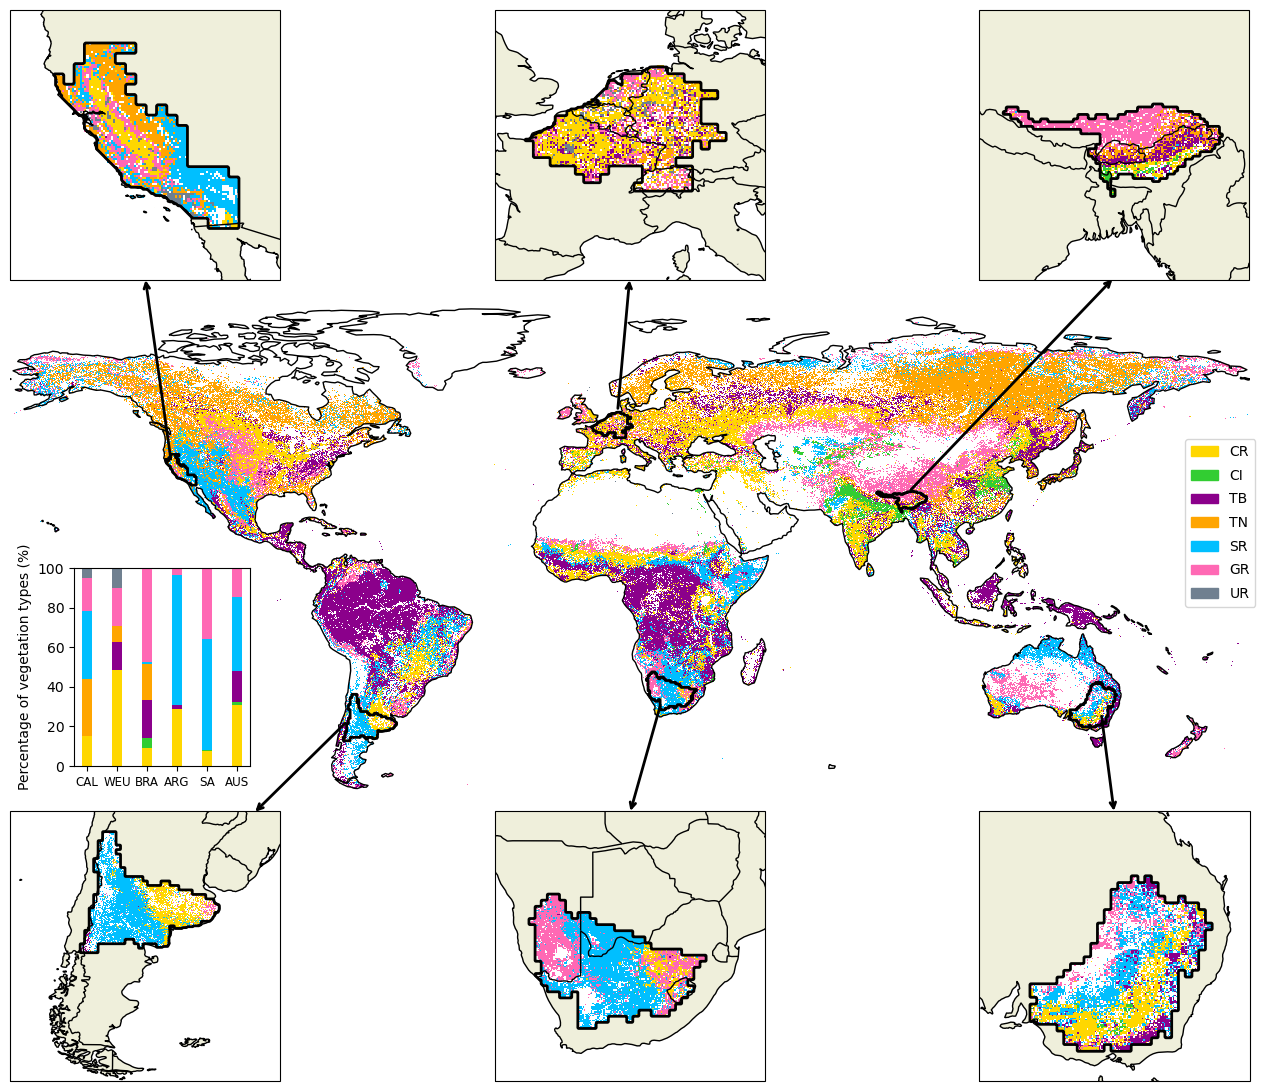

In [46]:
lc = lc
style = "white"
resolution = "0_1_degrees"
focus_regions = True
savefig = True

plot_worldmap(lc, style, resolution, focus_regions, savefig)